In [12]:
#these python packages are needed to run the code provided here
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import spatial
from itertools import chain
from more_itertools import sliced
from matplotlib.ticker import MaxNLocator
import random as rd


In [23]:
class display_2d_map():
    
    def __init__(self, protein_rg2,protein_ree2,radius_= 0.1,max_x_val=3,max_y_val=30):
        
        #initialize the list containing protein Rg^2 values and list containing protein Ree^2 values
        self.protein_rg2 = protein_rg2
        self.protein_ree2 = protein_ree2
        
        #initialize the reference GW chain data (by default a GW chain with 100 monomers is used)
        #any file containing GW reference chain data must be a pandas df containing 'Rg2' and 'Rend2' columns
        #the 'Rg2' is radius-of-gyration^2 and 'Rend2' is end-to-end-distance^2
        #the instantaneous shape ratio is calculated here
        #the file containing GW reference chain data should also have Rg/Rg_mean data
        #the self.testeq_GW MUST be single chain length data
        self.testeq_GW = pd.read_csv('GW_chainlen100.csv')
        self.testeq_GW['ratio'] = self.testeq_GW['Rend2'].values/self.testeq_GW['Rg2'].values
        
        #double check if the provided inputs are lists, they should be simple lists
        if not isinstance(self.protein_rg2, list) or not isinstance(self.protein_rg2, list):
            print('There seems to be an error. Rg2 and Ree2 input should be lists.')        
        
        #the default radius is 0.1
        self.radius_ = radius_
        
        #the default xlim max is 3 and xlim min is 0
        #the default ylim max is 30 and ylim min is 0        
        self.max_x_val=max_x_val
        self.max_y_val=max_y_val  
        
        #by default, using all protein snapshots provided in the datafile (can be modified here if needed)
        self.upto_protein_snapshots = len(self.protein_ree2)
        
        #by default using all GW snapshots provided in the datafile
        self.GW_every_ith_snap = self.testeq_GW.shape[0]
        
        #initialize the protein dataframe and both GW and protein coordinates
        self.organize_data(self.protein_rg2,self.protein_ree2,self.upto_protein_snapshots,self.GW_every_ith_snap)
        
    def plot_protein_against_GW(self,protein_label,provided_color='magenta'):

        #x-axis label and y-axis label
        x_variable=r'$R_g\left/R_g^{mean}\right.$' 
        y_variable="Instantaneous Shape Ratio"        
 
        %time
        %matplotlib inline
        plt.rcParams["font.weight"] = "regular"
        plt.rcParams["axes.labelweight"] = "regular"
        
        #several scatter plot markers are set here
        scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]

        #save x_total and y_total and x_polmodel_GW and y_polmodel_GW as simple lists
        x_total = self.poly_var['Rg/Rg_mean'].values.tolist()
        y_total = self.poly_var['ratio'].values.tolist()
        x_polmodel_GW = self.testeq_GW['Rg/Rg_mean'].values.tolist()
        y_polmodel_GW = self.testeq_GW['ratio'].values.tolist()

        #calculate fC value using fC method provided in class
        self.fC_value = self.fC_using_cdist(self.upto_protein_snapshots,
                                           self.GW_every_ith_snap,protein_name = 'protein')        

        #the rest of this function is plotting

        #Earlier in the class the default max_x_val and max_y_val were initialized (these are axis limits)
        #There is a separate method in the class if these default xlim and ylim values need to be changed
        #below it checks whether datapoints exceed the axis limits, provides an error if any limit is exceeded
        #the minimum axis limit for both x- and y-axis is 0
        xlims = [0,self.max_x_val]
        ylims = [0,self.max_y_val]
        if self.testeq_GW['Rg/Rg_mean'].max()>self.max_x_val or self.testeq_GW['Rg/Rg_mean'].min()<0:
            return print('ERROR, please re-examine axis limits')
        elif max(x_total)>self.max_x_val or min(x_total)<0:
            return print('ERROR, please re-examine axis limits')        
        elif self.testeq_GW['ratio'].max()>self.max_y_val or self.testeq_GW['ratio'].min()<0:
            return print('ERROR, please re-examine axis limits')
        elif max(y_total)>self.max_y_val or min(y_total)<0:
            return print('ERROR, please re-examine axis limits')        

        # Set up x and y labels
        xlabel = x_variable
        ylabel = y_variable

        # Define the locations for the axes (can modify as user wants), dimensions of each plot
        left, width = 0.12, 0.55
        bottom, height = 0.12, 0.55
        bottom_h = left_h = left+width
        rect_temperature = [left, bottom, width, height] # dimensions of temp plot
        rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
        rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

        # Set up the size of the figure (can modify as user wants)
        fig = plt.figure(1, figsize=(9.5,9))

        # Make the three plots
        # axTemperature is the scatter plot
        # axHistx and axHisty are the histograms on the top and side respectively
        axTemperature = plt.axes(rect_temperature) 
        axHistx = plt.axes(rect_histx) # x-axis histogram
        axHisty = plt.axes(rect_histy) # y-axis histogram

        #the xlims variable was previously described (contains axis limits for both axes)
        xmin = min(xlims)
        xmax = max(xlims)
        ymin = min(ylims)
        ymax = max(ylims)

        #Define the number of bins
        nxbins = 100
        nybins = 50
        nbins = nxbins+nybins
        
        #plot the reference GW scatter plot (Rg/Rg_mean against instantaneous shape ratio)
        axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                          marker=scatter_markers[3],s=40,alpha=0.6,color='black',
                           label='GW')

        #plot the protein scatter plot (Rg/Rg_mean against instantaneous shape ratio)
        axTemperature.scatter(x_total,
                   y_total,
                   marker=scatter_markers[0],s=40,alpha=0.6,color=provided_color,
                                          label=protein_label)                
        
        self.plot_style(axTemperature,xlabel,
                        ylabel,fontsize = 19, labelsize = 22, rotation = 0)

        #Set axis limits for scatter plot
        axTemperature.set_xlim(xlims)
        axTemperature.set_ylim(ylims)

        #Set up the histogram bins
        xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
        ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)

        #plot the histograms on the top and side
        axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',
                    alpha=0.5,density=True)
        axHistx.hist(x_total, bins=xbins, color = provided_color,
                    alpha=0.5,density=True)

        axHisty.hist(y_polmodel_GW, bins=ybins, color = 'black',orientation='horizontal',
                    alpha=0.5,density=True)

        axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',
                    alpha=0.5,density=True)

        #it does not matter what i set as xlabel for axHistx and ylabel for axHisty b/c i will remove these labels
        self.plot_style(axHistx,xlabel,
                        'Prob. Density',fontsize = 19, labelsize = 22, rotation = 0)
        self.plot_style(axHisty,'Prob. Density',
                        ylabel,fontsize = 19, labelsize = 22, rotation = 0)

        #add text on the scatter plot window, showing fC score 
        axTemperature.text(0.7,0.65,
                           '$f_C$ = '+format(self.fC_value,'0.3f'),
                          transform=axTemperature.transAxes,fontsize=18)
        
        #add legend for scatter plot
        axTemp_legend=axTemperature.legend(fontsize=15,loc='upper right')
        
        #cosmetic modifications
        frame = axTemp_legend.get_frame()
        frame.set_linewidth(1.6)
        frame.set_edgecolor('black')

        #Set up the histogram axis limits
        axHistx.set_xlim( xmin, xmax )
        axHisty.set_ylim( ymin, ymax )

        #cosmetic modifications
        axHisty.xaxis.set_major_locator(MaxNLocator(4))
        axHistx.yaxis.set_major_locator(MaxNLocator(3))
                    
        #for the x-axis and y-axis histograms, remove any marks or ticks on the x and y axis respectively
        axHistx.axes.get_xaxis().set_visible(False)
        axHisty.axes.get_yaxis().set_visible(False)

        plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
        plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
        
    #this function calculates fC score
    def fC_using_cdist(self,upto_protein_snapshots,GW_every_ith_snap,protein_name = 'protein'):
        
        self.organize_data(self.protein_rg2,self.protein_ree2,upto_protein_snapshots,GW_every_ith_snap)
        #iterate through each GW point and identify the GW points that do NOT have protein points in range
        protein_not_in_range=[]
        j=0
        for point in self.GW_points:

            if not self.tree_protein.query_ball_point(point,self.radius_):
                protein_not_in_range.append(point)
            j+=1
            
        #find the number of GW points that have protein points in their range
        #that number is found by subtracting # of GW points without proteins in range from total # of GW points
        #calculate fC by dividing # of GW points with protein points in range by total # of GW points
        fC_by_distance=(self.GW_points.shape[0]-len(protein_not_in_range))/(self.GW_points.shape[0])

        #re-initialize the self.GW_points and self.protein_points AND other data
        self.organize_data(self.protein_rg2,self.protein_ree2,self.upto_protein_snapshots,self.GW_every_ith_snap)
        return fC_by_distance    

    def check_boundary(self,protein_name = 'protein'):
        #the code in this method is very similar to the fC_using_cdist method
        
        protein_not_in_range=[]
        j=0
        for point in self.protein_points:
            if not self.tree_GW.query_ball_point(point,self.radius_):
                protein_not_in_range.append(point)
            j+=1
            
        bounded_fraction=(self.protein_points.shape[0]-len(protein_not_in_range))/(self.protein_points.shape[0])
        self.bounded_fraction = bounded_fraction
        return print(f'{format(bounded_fraction*100,"0.2f")}% of protein snapshots are close to GW snapshots')
    
    def change_xlim_ylim(self,max_x_val,max_y_val):
        #the default xlim max is 3 and xlim min is 0
        #the default ylim max is 30 and ylim min is 0
        #this method is needed if either the reference Rg/Rg_mean or shape ratio exceeds current default axis lims
        self.max_x_val = max_x_val
        self.max_y_val = max_y_val
        print('New axis limits generated')
        
    def vary_GW_ref(self, protein_lab, every_yth_snap):
        print('if it takes too long to run, please consider a higher snapshot interval')
        #every_yth_snap should be modified based on number of GW snapshots available
        #too many snapshots take longer to process

        fig,ax = plt.subplots(figsize=(10,8))

        ref_snaps=[]
        fC_vary_ref=[]
        for GW_ref_snapshots in range(every_yth_snap,self.testeq_GW.shape[0]+every_yth_snap,
                                    every_yth_snap):
            ref_snaps.append(GW_ref_snapshots)
            fC_vary_ref.append(self.fC_using_cdist(self.upto_protein_snapshots,
                                               GW_ref_snapshots,protein_name = 'protein'))

        ax.scatter(ref_snaps,
                   fC_vary_ref,
                   color='darkorange',label=protein_lab,
                   marker='s',s=80)


        ax.plot(ref_snaps,
               fC_vary_ref,
               color='darkorange')
        self.plot_style(ax,'number of GW snapshots (x $10^6$)',
                        '$f_C$',fontsize = 19, labelsize = 22, rotation = 45)
        ax.legend(fontsize=16)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(x/10**6, '0.2f')))        
    def regenerate_GW_chain(self,chain_length,nosnaps,interval=1,mu=0,sigma=1):
        chain_length=chain_length
        x = np.zeros(chain_length)
        y = np.zeros(chain_length)
        z = np.zeros(chain_length)
        nosnaps = nosnaps
        interval=interval
        snapshot=0
        mu = mu
        sigma = sigma #kuhn length
        Rend2 = []
        Rg2 = []
        while snapshot<(nosnaps*interval):
            for i in range(1,chain_length,1):
                x[i] = x[i-1] + rd.gauss(mu,sigma)
                y[i] = y[i-1] + rd.gauss(mu,sigma)
                z[i] = z[i-1] + rd.gauss(mu,sigma)        
            if snapshot in np.arange(0,(nosnaps*interval),interval):
                Rend2.append(self.Ree2(x,y,z))
                Rg2.append(self.Rgx2(x,chain_length)+self.Rgy2(y,chain_length)+self.Rgz2(z,chain_length))
            snapshot = snapshot + 1   
        master_out=pd.DataFrame(np.array([Rg2,
                           Rend2]).T,columns=['Rg2','Rend2'])
        master_out.insert(0,'chain_length',np.repeat(chain_length,nosnaps))
        rg_val = np.array(master_out.Rg2)**0.5
        rg_mean = np.mean(rg_val)
        master_out['Rg/Rg_mean'] = rg_val/rg_mean
        del rg_val, rg_mean
        self.testeq_GW = master_out.copy()
        self.testeq_GW['ratio'] = self.testeq_GW['Rend2'].values/self.testeq_GW['Rg2'].values
        print(f'New GW reference chain of length {chain_length} has been initialized for this instance')
        return master_out
    def Ree2(self,x,y,z):
        return ((x[0]-x[len(x)-1])**2+(y[0]-y[len(y)-1])**2+(z[0]-z[len(z)-1])**2)
    def Rgx2(self,x,chain_length): 
        Rgx = np.sum((x - np.mean(x))**2)/chain_length
        return Rgx
    def Rgy2(self,y,chain_length): 
        Rgy = np.sum((y - np.mean(y))**2)/chain_length
        return Rgy
    def Rgz2(self,z,chain_length): 
        Rgz = np.sum((z - np.mean(z))**2)/chain_length
        return Rgz
    def save_GW_chain_to_csv(self):
        #GW datafile must contain only one chain length
        #will be saved to current directory
        self.testeq_GW.to_csv("GW_chainlen{self.testeq_GW.chain_length.unique()[0]}.csv",index=False)
    def retrieve_default_GW_chain(self):
        self.testeq_GW = pd.read_csv('GW_chainlen100.csv')
        self.testeq_GW['ratio'] = self.testeq_GW['Rend2'].values/self.testeq_GW['Rg2'].values
    def plot_style(self,ax,xlabel,ylabel,fontsize = 19, labelsize = 22, rotation = 0):
        plt.setp(ax.get_xticklabels(),fontsize=fontsize,rotation=rotation)
        plt.setp(ax.get_yticklabels(),fontsize=fontsize)
        ax.set_xlabel(xlabel,fontsize=labelsize)
        ax.set_ylabel(ylabel,fontsize=labelsize)
        for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
        ax.minorticks_on()
        ax.tick_params(axis='both', which='major', labelsize=fontsize, width = 1.7, size = 8,pad=10)
        ax.tick_params(axis='both', which='minor', width = 1.2, size = 5) 
    def organize_data(self, provided_rg2, provided_ree2,upto_protein_snapshots,GW_every_ith_snap,
                      protein_name = 'protein'):
        
        #calculate Rg values from Rg2 values for protein
        #calculate a Rg_mean value for protein using all the Rg2 values from entire protein simulation
        #calculate protein shape ratio value as well
        protein_rg = np.array(provided_rg2)**0.5
        rg_mean = np.mean(protein_rg)
        protein_ratio = np.array(provided_ree2)/np.array(provided_rg2)
        protein_relative_rg = protein_rg/rg_mean

        #arbitrary name just for this method 
        protein_label='protein_'+protein_name    

        #create a pandas dataframe of Rg/Rg_mean and instantaneous shape ratio for protein
        self.poly_var = pd.DataFrame(data = zip(protein_relative_rg,
                                         protein_ratio),columns=['Rg/Rg_mean','ratio']).copy()

        protein_pro = self.poly_var[['Rg/Rg_mean','ratio']].iloc[:upto_protein_snapshots,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])

        #the GW_po variable is for GW
        GW_po=self.testeq_GW[['Rg/Rg_mean','ratio']].iloc[:GW_every_ith_snap,:].copy()
        GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])

        #calculate mean and stdev values (must keep same mean and stdev values)
        #calculating mean and stdev values of Rg/Rg_mean and shape ratio for GW
        upto_snapshots=720000
        GW_mean_Rg_Rg_mean=np.mean(self.testeq_GW['Rg/Rg_mean'].values[0:(upto_snapshots+1)])
        GW_std_Rg_Rg_mean=np.std(self.testeq_GW['Rg/Rg_mean'].values[0:(upto_snapshots+1)])
        GW_mean_ratio=np.mean(self.testeq_GW['ratio'].values[0:(upto_snapshots+1)])
        GW_std_ratio=np.std(self.testeq_GW['ratio'].values[0:(upto_snapshots+1)])

        #create a pandas dataframe with combined GW and protein Rg/Rg_mean and instantaneous shape ratio 
        combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)

        #transform all the Rg/Rg_mean and ins. shape ratio values (belonging to both protein and GW)
        #stdd just means transformed or standardized
        combined_pro_po['stdd_Rg/Rg_mean']=(combined_pro_po['Rg/Rg_mean'].values-GW_mean_Rg_Rg_mean)/(GW_std_Rg_Rg_mean)
        combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)

        #isolate the transformed Rg/Rg_mean and instantaneous shape ratio values into separate variables
        #separate Rg/Rg_mean and instantaneous shape ratio variable for protein & GW
        po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_Rg/Rg_mean'].values
        po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
        pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_Rg/Rg_mean'].values
        pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values

        #use protein and transformed GW Rg/Rg_mean and ins. shape ratio values as coordinates
        #GW_points represents coordinates for GW in the format (Rg/Rg_mean, ins. shape ratio)
        #protein_points represents coordinates for protein in that same format
        #these (Rg/Rg_mean, ins. shape ratio) values are transformed values
        self.GW_points=np.c_[po_x, po_y]
        self.protein_points=np.c_[pro_x, pro_y]            
        
        self.tree_GW=spatial.cKDTree(self.GW_points)
        self.tree_protein=spatial.cKDTree(self.protein_points)        
    def vary_protein(self, protein_lab, interv):
        print('if it takes too long to run, please consider a higher snapshot interval')        
        temp_df = pd.DataFrame(data = zip(self.protein_rg2,self.protein_ree2),columns=['Rg2','Ree2']).copy()
        protein_snaps = []
        fC_vary_protein = []

        fig,ax = plt.subplots(figsize=(10,8))
        #here i am applying the sliced function from more_itertools to divide my dataframe into chunks
        #if the last chunk has fewer rows (i.e. less than the defined interval) than previous chunks than that is fine
        temp_df_index_slices = sliced(range(len(temp_df)), interv)
        allGW_indx = np.array(range(0,self.GW_points.shape[0]))        
        
        j=0
        for index_slice in temp_df_index_slices:

            #each chunk has different start point and end point
            chunk = temp_df.iloc[index_slice] 

            #protein_snaps is appending 0 to current end point from the 'chunk' df
            protein_snaps.append(temp_df[0:(chunk.iloc[-1].name)+1].shape[0])

            temp_rg2 = list(chunk.Rg2.values)
            temp_ree2 = list(chunk.Ree2.values)    
                
            self.organize_data(temp_rg2,temp_ree2,len(temp_ree2),self.GW_every_ith_snap)

            temp_protein_not_in_range = []
            for point,ind in zip(self.GW_points,allGW_indx):
                if not self.tree_protein.query_ball_point(point,self.radius_):
                    temp_protein_not_in_range.append(ind)
            temp_protein_not_in_range = np.array(temp_protein_not_in_range)
            temp_protein_in_range = allGW_indx[~np.isin(allGW_indx,temp_protein_not_in_range)]
            if j==0:
                master_point_list = temp_protein_in_range
            elif j>0:
                master_point_list = np.unique(np.append(master_point_list,temp_protein_in_range))
                
            temp_fC_value = (master_point_list.shape[0])/(self.GW_points.shape[0])

            fC_vary_protein.append(temp_fC_value)
            
            j+=1
        ax.scatter(protein_snaps,
                   fC_vary_protein,
                   color='darkorange',label=protein_lab,
                   marker='s',s=80)

        ax.plot(protein_snaps,
               fC_vary_protein,
               color='darkorange')
        self.plot_style(ax,f'number of {protein_lab} snapshots',
                        '$f_C$',fontsize = 19, labelsize = 22, rotation = 45)

        #re-initialize the self.GW_points and self.protein_points AND other data
        self.organize_data(self.protein_rg2,self.protein_ree2,self.upto_protein_snapshots,self.GW_every_ith_snap)
#     def vary_GW_ref(self, protein_lab, interv):
#         print('if it takes too long to run, please consider a higher snapshot interval')
#         #interv should be modified based on number of GW snapshots available
#         #too many snapshots take longer to process
#         temp_df_GW = self.testeq_GW.copy()
#         fig,ax = plt.subplots(figsize=(10,8))
#         ref_snaps=[]
#         fC_vary_ref=[]

#         #here i am applying the sliced function from more_itertools to divide my dataframe into chunks
#         #if the last chunk has fewer rows (i.e. less than the defined interval) than previous chunks than that is fine
#         temp_df_index_slices = sliced(range(len(temp_df_GW)), interv)
#         j=0
#         for index_slice in temp_df_index_slices:

#             #each chunk has different start point and end point
#             chunk = temp_df_GW.iloc[index_slice] 

#             #ref_snaps is appending 0 to current end point from the 'chunk' df
#             ref_snaps.append(temp_df_GW[0:(chunk.iloc[-1].name)+1].shape[0])

#             temp_rg2 = list(chunk.Rg2.values)
#             temp_ree2 = list(chunk.Rend2.values)    
                
#             self.organize_data(temp_rg2,temp_ree2,self.upto_protein_snapshots,len(temp_ree2))
#             allGW_indx = np.array(range(0,self.GW_points.shape[0]))
#             temp_protein_not_in_range = []
#             for point,ind in zip(self.GW_points,allGW_indx):
#                 if not self.tree_protein.query_ball_point(point,self.radius_):
#                     temp_protein_not_in_range.append(ind)
#             temp_protein_not_in_range = np.array(temp_protein_not_in_range)
#             temp_protein_in_range = allGW_indx[~np.isin(allGW_indx,temp_protein_not_in_range)]
#             if j==0:
#                 master_point_list = temp_protein_in_range
#             elif j>0:
#                 master_point_list = np.unique(np.append(master_point_list,temp_protein_in_range))
                
#             temp_fC_value = (master_point_list.shape[0])/(self.GW_points.shape[0])

#             fC_vary_ref.append(temp_fC_value)
            
#             j+=1
#         ax.scatter(ref_snaps,
#                    fC_vary_ref,
#                    color='darkorange',label=protein_lab,
#                    marker='s',s=80)
#         ax.plot(ref_snaps,
#                fC_vary_ref,
#                color='darkorange')
#         self.plot_style(ax,'number of GW snapshots (x $10^6$)',
#                         '$f_C$',fontsize = 19, labelsize = 22, rotation = 45)
#         ax.legend(fontsize=16)
#         ax.get_xaxis().set_major_formatter(
#         matplotlib.ticker.FuncFormatter(lambda x, p: format(x/10**6, '0.2f')))        

#         #re-initialize the self.GW_points and self.protein_points AND other data
#         self.organize_data(self.protein_rg2,self.protein_ree2,self.upto_protein_snapshots,self.GW_every_ith_snap)
        

In [29]:
test_np=map_2d.GW_points



In [31]:
for ix,iy in np.ndindex(test_np.shape):
    print(ix,iy)

0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1
4 0
4 1
5 0
5 1
6 0
6 1
7 0
7 1
8 0
8 1
9 0
9 1
10 0
10 1
11 0
11 1
12 0
12 1
13 0
13 1
14 0
14 1
15 0
15 1
16 0
16 1
17 0
17 1
18 0
18 1
19 0
19 1
20 0
20 1
21 0
21 1
22 0
22 1
23 0
23 1
24 0
24 1
25 0
25 1
26 0
26 1
27 0
27 1
28 0
28 1
29 0
29 1
30 0
30 1
31 0
31 1
32 0
32 1
33 0
33 1
34 0
34 1
35 0
35 1
36 0
36 1
37 0
37 1
38 0
38 1
39 0
39 1
40 0
40 1
41 0
41 1
42 0
42 1
43 0
43 1
44 0
44 1
45 0
45 1
46 0
46 1
47 0
47 1
48 0
48 1
49 0
49 1
50 0
50 1
51 0
51 1
52 0
52 1
53 0
53 1
54 0
54 1
55 0
55 1
56 0
56 1
57 0
57 1
58 0
58 1
59 0
59 1
60 0
60 1
61 0
61 1
62 0
62 1
63 0
63 1
64 0
64 1
65 0
65 1
66 0
66 1
67 0
67 1
68 0
68 1
69 0
69 1
70 0
70 1
71 0
71 1
72 0
72 1
73 0
73 1
74 0
74 1
75 0
75 1
76 0
76 1
77 0
77 1
78 0
78 1
79 0
79 1
80 0
80 1
81 0
81 1
82 0
82 1
83 0
83 1
84 0
84 1
85 0
85 1
86 0
86 1
87 0
87 1
88 0
88 1
89 0
89 1
90 0
90 1
91 0
91 1
92 0
92 1
93 0
93 1
94 0
94 1
95 0
95 1
96 0
96 1
97 0
97 1
98 0
98 1
99 0
99 1
100 0
100 1
101 0
10

861 0
861 1
862 0
862 1
863 0
863 1
864 0
864 1
865 0
865 1
866 0
866 1
867 0
867 1
868 0
868 1
869 0
869 1
870 0
870 1
871 0
871 1
872 0
872 1
873 0
873 1
874 0
874 1
875 0
875 1
876 0
876 1
877 0
877 1
878 0
878 1
879 0
879 1
880 0
880 1
881 0
881 1
882 0
882 1
883 0
883 1
884 0
884 1
885 0
885 1
886 0
886 1
887 0
887 1
888 0
888 1
889 0
889 1
890 0
890 1
891 0
891 1
892 0
892 1
893 0
893 1
894 0
894 1
895 0
895 1
896 0
896 1
897 0
897 1
898 0
898 1
899 0
899 1
900 0
900 1
901 0
901 1
902 0
902 1
903 0
903 1
904 0
904 1
905 0
905 1
906 0
906 1
907 0
907 1
908 0
908 1
909 0
909 1
910 0
910 1
911 0
911 1
912 0
912 1
913 0
913 1
914 0
914 1
915 0
915 1
916 0
916 1
917 0
917 1
918 0
918 1
919 0
919 1
920 0
920 1
921 0
921 1
922 0
922 1
923 0
923 1
924 0
924 1
925 0
925 1
926 0
926 1
927 0
927 1
928 0
928 1
929 0
929 1
930 0
930 1
931 0
931 1
932 0
932 1
933 0
933 1
934 0
934 1
935 0
935 1
936 0
936 1
937 0
937 1
938 0
938 1
939 0
939 1
940 0
940 1
941 0
941 1
942 0
942 1
943 0
943 1
944 

1692 1
1693 0
1693 1
1694 0
1694 1
1695 0
1695 1
1696 0
1696 1
1697 0
1697 1
1698 0
1698 1
1699 0
1699 1
1700 0
1700 1
1701 0
1701 1
1702 0
1702 1
1703 0
1703 1
1704 0
1704 1
1705 0
1705 1
1706 0
1706 1
1707 0
1707 1
1708 0
1708 1
1709 0
1709 1
1710 0
1710 1
1711 0
1711 1
1712 0
1712 1
1713 0
1713 1
1714 0
1714 1
1715 0
1715 1
1716 0
1716 1
1717 0
1717 1
1718 0
1718 1
1719 0
1719 1
1720 0
1720 1
1721 0
1721 1
1722 0
1722 1
1723 0
1723 1
1724 0
1724 1
1725 0
1725 1
1726 0
1726 1
1727 0
1727 1
1728 0
1728 1
1729 0
1729 1
1730 0
1730 1
1731 0
1731 1
1732 0
1732 1
1733 0
1733 1
1734 0
1734 1
1735 0
1735 1
1736 0
1736 1
1737 0
1737 1
1738 0
1738 1
1739 0
1739 1
1740 0
1740 1
1741 0
1741 1
1742 0
1742 1
1743 0
1743 1
1744 0
1744 1
1745 0
1745 1
1746 0
1746 1
1747 0
1747 1
1748 0
1748 1
1749 0
1749 1
1750 0
1750 1
1751 0
1751 1
1752 0
1752 1
1753 0
1753 1
1754 0
1754 1
1755 0
1755 1
1756 0
1756 1
1757 0
1757 1
1758 0
1758 1
1759 0
1759 1
1760 0
1760 1
1761 0
1761 1
1762 0
1762 1
1763 0
1763 1

2567 1
2568 0
2568 1
2569 0
2569 1
2570 0
2570 1
2571 0
2571 1
2572 0
2572 1
2573 0
2573 1
2574 0
2574 1
2575 0
2575 1
2576 0
2576 1
2577 0
2577 1
2578 0
2578 1
2579 0
2579 1
2580 0
2580 1
2581 0
2581 1
2582 0
2582 1
2583 0
2583 1
2584 0
2584 1
2585 0
2585 1
2586 0
2586 1
2587 0
2587 1
2588 0
2588 1
2589 0
2589 1
2590 0
2590 1
2591 0
2591 1
2592 0
2592 1
2593 0
2593 1
2594 0
2594 1
2595 0
2595 1
2596 0
2596 1
2597 0
2597 1
2598 0
2598 1
2599 0
2599 1
2600 0
2600 1
2601 0
2601 1
2602 0
2602 1
2603 0
2603 1
2604 0
2604 1
2605 0
2605 1
2606 0
2606 1
2607 0
2607 1
2608 0
2608 1
2609 0
2609 1
2610 0
2610 1
2611 0
2611 1
2612 0
2612 1
2613 0
2613 1
2614 0
2614 1
2615 0
2615 1
2616 0
2616 1
2617 0
2617 1
2618 0
2618 1
2619 0
2619 1
2620 0
2620 1
2621 0
2621 1
2622 0
2622 1
2623 0
2623 1
2624 0
2624 1
2625 0
2625 1
2626 0
2626 1
2627 0
2627 1
2628 0
2628 1
2629 0
2629 1
2630 0
2630 1
2631 0
2631 1
2632 0
2632 1
2633 0
2633 1
2634 0
2634 1
2635 0
2635 1
2636 0
2636 1
2637 0
2637 1
2638 0
2638 1

3442 1
3443 0
3443 1
3444 0
3444 1
3445 0
3445 1
3446 0
3446 1
3447 0
3447 1
3448 0
3448 1
3449 0
3449 1
3450 0
3450 1
3451 0
3451 1
3452 0
3452 1
3453 0
3453 1
3454 0
3454 1
3455 0
3455 1
3456 0
3456 1
3457 0
3457 1
3458 0
3458 1
3459 0
3459 1
3460 0
3460 1
3461 0
3461 1
3462 0
3462 1
3463 0
3463 1
3464 0
3464 1
3465 0
3465 1
3466 0
3466 1
3467 0
3467 1
3468 0
3468 1
3469 0
3469 1
3470 0
3470 1
3471 0
3471 1
3472 0
3472 1
3473 0
3473 1
3474 0
3474 1
3475 0
3475 1
3476 0
3476 1
3477 0
3477 1
3478 0
3478 1
3479 0
3479 1
3480 0
3480 1
3481 0
3481 1
3482 0
3482 1
3483 0
3483 1
3484 0
3484 1
3485 0
3485 1
3486 0
3486 1
3487 0
3487 1
3488 0
3488 1
3489 0
3489 1
3490 0
3490 1
3491 0
3491 1
3492 0
3492 1
3493 0
3493 1
3494 0
3494 1
3495 0
3495 1
3496 0
3496 1
3497 0
3497 1
3498 0
3498 1
3499 0
3499 1
3500 0
3500 1
3501 0
3501 1
3502 0
3502 1
3503 0
3503 1
3504 0
3504 1
3505 0
3505 1
3506 0
3506 1
3507 0
3507 1
3508 0
3508 1
3509 0
3509 1
3510 0
3510 1
3511 0
3511 1
3512 0
3512 1
3513 0
3513 1

4411 1
4412 0
4412 1
4413 0
4413 1
4414 0
4414 1
4415 0
4415 1
4416 0
4416 1
4417 0
4417 1
4418 0
4418 1
4419 0
4419 1
4420 0
4420 1
4421 0
4421 1
4422 0
4422 1
4423 0
4423 1
4424 0
4424 1
4425 0
4425 1
4426 0
4426 1
4427 0
4427 1
4428 0
4428 1
4429 0
4429 1
4430 0
4430 1
4431 0
4431 1
4432 0
4432 1
4433 0
4433 1
4434 0
4434 1
4435 0
4435 1
4436 0
4436 1
4437 0
4437 1
4438 0
4438 1
4439 0
4439 1
4440 0
4440 1
4441 0
4441 1
4442 0
4442 1
4443 0
4443 1
4444 0
4444 1
4445 0
4445 1
4446 0
4446 1
4447 0
4447 1
4448 0
4448 1
4449 0
4449 1
4450 0
4450 1
4451 0
4451 1
4452 0
4452 1
4453 0
4453 1
4454 0
4454 1
4455 0
4455 1
4456 0
4456 1
4457 0
4457 1
4458 0
4458 1
4459 0
4459 1
4460 0
4460 1
4461 0
4461 1
4462 0
4462 1
4463 0
4463 1
4464 0
4464 1
4465 0
4465 1
4466 0
4466 1
4467 0
4467 1
4468 0
4468 1
4469 0
4469 1
4470 0
4470 1
4471 0
4471 1
4472 0
4472 1
4473 0
4473 1
4474 0
4474 1
4475 0
4475 1
4476 0
4476 1
4477 0
4477 1
4478 0
4478 1
4479 0
4479 1
4480 0
4480 1
4481 0
4481 1
4482 0
4482 1

5192 0
5192 1
5193 0
5193 1
5194 0
5194 1
5195 0
5195 1
5196 0
5196 1
5197 0
5197 1
5198 0
5198 1
5199 0
5199 1
5200 0
5200 1
5201 0
5201 1
5202 0
5202 1
5203 0
5203 1
5204 0
5204 1
5205 0
5205 1
5206 0
5206 1
5207 0
5207 1
5208 0
5208 1
5209 0
5209 1
5210 0
5210 1
5211 0
5211 1
5212 0
5212 1
5213 0
5213 1
5214 0
5214 1
5215 0
5215 1
5216 0
5216 1
5217 0
5217 1
5218 0
5218 1
5219 0
5219 1
5220 0
5220 1
5221 0
5221 1
5222 0
5222 1
5223 0
5223 1
5224 0
5224 1
5225 0
5225 1
5226 0
5226 1
5227 0
5227 1
5228 0
5228 1
5229 0
5229 1
5230 0
5230 1
5231 0
5231 1
5232 0
5232 1
5233 0
5233 1
5234 0
5234 1
5235 0
5235 1
5236 0
5236 1
5237 0
5237 1
5238 0
5238 1
5239 0
5239 1
5240 0
5240 1
5241 0
5241 1
5242 0
5242 1
5243 0
5243 1
5244 0
5244 1
5245 0
5245 1
5246 0
5246 1
5247 0
5247 1
5248 0
5248 1
5249 0
5249 1
5250 0
5250 1
5251 0
5251 1
5252 0
5252 1
5253 0
5253 1
5254 0
5254 1
5255 0
5255 1
5256 0
5256 1
5257 0
5257 1
5258 0
5258 1
5259 0
5259 1
5260 0
5260 1
5261 0
5261 1
5262 0
5262 1
5263 0

6192 0
6192 1
6193 0
6193 1
6194 0
6194 1
6195 0
6195 1
6196 0
6196 1
6197 0
6197 1
6198 0
6198 1
6199 0
6199 1
6200 0
6200 1
6201 0
6201 1
6202 0
6202 1
6203 0
6203 1
6204 0
6204 1
6205 0
6205 1
6206 0
6206 1
6207 0
6207 1
6208 0
6208 1
6209 0
6209 1
6210 0
6210 1
6211 0
6211 1
6212 0
6212 1
6213 0
6213 1
6214 0
6214 1
6215 0
6215 1
6216 0
6216 1
6217 0
6217 1
6218 0
6218 1
6219 0
6219 1
6220 0
6220 1
6221 0
6221 1
6222 0
6222 1
6223 0
6223 1
6224 0
6224 1
6225 0
6225 1
6226 0
6226 1
6227 0
6227 1
6228 0
6228 1
6229 0
6229 1
6230 0
6230 1
6231 0
6231 1
6232 0
6232 1
6233 0
6233 1
6234 0
6234 1
6235 0
6235 1
6236 0
6236 1
6237 0
6237 1
6238 0
6238 1
6239 0
6239 1
6240 0
6240 1
6241 0
6241 1
6242 0
6242 1
6243 0
6243 1
6244 0
6244 1
6245 0
6245 1
6246 0
6246 1
6247 0
6247 1
6248 0
6248 1
6249 0
6249 1
6250 0
6250 1
6251 0
6251 1
6252 0
6252 1
6253 0
6253 1
6254 0
6254 1
6255 0
6255 1
6256 0
6256 1
6257 0
6257 1
6258 0
6258 1
6259 0
6259 1
6260 0
6260 1
6261 0
6261 1
6262 0
6262 1
6263 0

7067 0
7067 1
7068 0
7068 1
7069 0
7069 1
7070 0
7070 1
7071 0
7071 1
7072 0
7072 1
7073 0
7073 1
7074 0
7074 1
7075 0
7075 1
7076 0
7076 1
7077 0
7077 1
7078 0
7078 1
7079 0
7079 1
7080 0
7080 1
7081 0
7081 1
7082 0
7082 1
7083 0
7083 1
7084 0
7084 1
7085 0
7085 1
7086 0
7086 1
7087 0
7087 1
7088 0
7088 1
7089 0
7089 1
7090 0
7090 1
7091 0
7091 1
7092 0
7092 1
7093 0
7093 1
7094 0
7094 1
7095 0
7095 1
7096 0
7096 1
7097 0
7097 1
7098 0
7098 1
7099 0
7099 1
7100 0
7100 1
7101 0
7101 1
7102 0
7102 1
7103 0
7103 1
7104 0
7104 1
7105 0
7105 1
7106 0
7106 1
7107 0
7107 1
7108 0
7108 1
7109 0
7109 1
7110 0
7110 1
7111 0
7111 1
7112 0
7112 1
7113 0
7113 1
7114 0
7114 1
7115 0
7115 1
7116 0
7116 1
7117 0
7117 1
7118 0
7118 1
7119 0
7119 1
7120 0
7120 1
7121 0
7121 1
7122 0
7122 1
7123 0
7123 1
7124 0
7124 1
7125 0
7125 1
7126 0
7126 1
7127 0
7127 1
7128 0
7128 1
7129 0
7129 1
7130 0
7130 1
7131 0
7131 1
7132 0
7132 1
7133 0
7133 1
7134 0
7134 1
7135 0
7135 1
7136 0
7136 1
7137 0
7137 1
7138 0

7941 1
7942 0
7942 1
7943 0
7943 1
7944 0
7944 1
7945 0
7945 1
7946 0
7946 1
7947 0
7947 1
7948 0
7948 1
7949 0
7949 1
7950 0
7950 1
7951 0
7951 1
7952 0
7952 1
7953 0
7953 1
7954 0
7954 1
7955 0
7955 1
7956 0
7956 1
7957 0
7957 1
7958 0
7958 1
7959 0
7959 1
7960 0
7960 1
7961 0
7961 1
7962 0
7962 1
7963 0
7963 1
7964 0
7964 1
7965 0
7965 1
7966 0
7966 1
7967 0
7967 1
7968 0
7968 1
7969 0
7969 1
7970 0
7970 1
7971 0
7971 1
7972 0
7972 1
7973 0
7973 1
7974 0
7974 1
7975 0
7975 1
7976 0
7976 1
7977 0
7977 1
7978 0
7978 1
7979 0
7979 1
7980 0
7980 1
7981 0
7981 1
7982 0
7982 1
7983 0
7983 1
7984 0
7984 1
7985 0
7985 1
7986 0
7986 1
7987 0
7987 1
7988 0
7988 1
7989 0
7989 1
7990 0
7990 1
7991 0
7991 1
7992 0
7992 1
7993 0
7993 1
7994 0
7994 1
7995 0
7995 1
7996 0
7996 1
7997 0
7997 1
7998 0
7998 1
7999 0
7999 1
8000 0
8000 1
8001 0
8001 1
8002 0
8002 1
8003 0
8003 1
8004 0
8004 1
8005 0
8005 1
8006 0
8006 1
8007 0
8007 1
8008 0
8008 1
8009 0
8009 1
8010 0
8010 1
8011 0
8011 1
8012 0
8012 1

8816 1
8817 0
8817 1
8818 0
8818 1
8819 0
8819 1
8820 0
8820 1
8821 0
8821 1
8822 0
8822 1
8823 0
8823 1
8824 0
8824 1
8825 0
8825 1
8826 0
8826 1
8827 0
8827 1
8828 0
8828 1
8829 0
8829 1
8830 0
8830 1
8831 0
8831 1
8832 0
8832 1
8833 0
8833 1
8834 0
8834 1
8835 0
8835 1
8836 0
8836 1
8837 0
8837 1
8838 0
8838 1
8839 0
8839 1
8840 0
8840 1
8841 0
8841 1
8842 0
8842 1
8843 0
8843 1
8844 0
8844 1
8845 0
8845 1
8846 0
8846 1
8847 0
8847 1
8848 0
8848 1
8849 0
8849 1
8850 0
8850 1
8851 0
8851 1
8852 0
8852 1
8853 0
8853 1
8854 0
8854 1
8855 0
8855 1
8856 0
8856 1
8857 0
8857 1
8858 0
8858 1
8859 0
8859 1
8860 0
8860 1
8861 0
8861 1
8862 0
8862 1
8863 0
8863 1
8864 0
8864 1
8865 0
8865 1
8866 0
8866 1
8867 0
8867 1
8868 0
8868 1
8869 0
8869 1
8870 0
8870 1
8871 0
8871 1
8872 0
8872 1
8873 0
8873 1
8874 0
8874 1
8875 0
8875 1
8876 0
8876 1
8877 0
8877 1
8878 0
8878 1
8879 0
8879 1
8880 0
8880 1
8881 0
8881 1
8882 0
8882 1
8883 0
8883 1
8884 0
8884 1
8885 0
8885 1
8886 0
8886 1
8887 0
8887 1

9816 1
9817 0
9817 1
9818 0
9818 1
9819 0
9819 1
9820 0
9820 1
9821 0
9821 1
9822 0
9822 1
9823 0
9823 1
9824 0
9824 1
9825 0
9825 1
9826 0
9826 1
9827 0
9827 1
9828 0
9828 1
9829 0
9829 1
9830 0
9830 1
9831 0
9831 1
9832 0
9832 1
9833 0
9833 1
9834 0
9834 1
9835 0
9835 1
9836 0
9836 1
9837 0
9837 1
9838 0
9838 1
9839 0
9839 1
9840 0
9840 1
9841 0
9841 1
9842 0
9842 1
9843 0
9843 1
9844 0
9844 1
9845 0
9845 1
9846 0
9846 1
9847 0
9847 1
9848 0
9848 1
9849 0
9849 1
9850 0
9850 1
9851 0
9851 1
9852 0
9852 1
9853 0
9853 1
9854 0
9854 1
9855 0
9855 1
9856 0
9856 1
9857 0
9857 1
9858 0
9858 1
9859 0
9859 1
9860 0
9860 1
9861 0
9861 1
9862 0
9862 1
9863 0
9863 1
9864 0
9864 1
9865 0
9865 1
9866 0
9866 1
9867 0
9867 1
9868 0
9868 1
9869 0
9869 1
9870 0
9870 1
9871 0
9871 1
9872 0
9872 1
9873 0
9873 1
9874 0
9874 1
9875 0
9875 1
9876 0
9876 1
9877 0
9877 1
9878 0
9878 1
9879 0
9879 1
9880 0
9880 1
9881 0
9881 1
9882 0
9882 1
9883 0
9883 1
9884 0
9884 1
9885 0
9885 1
9886 0
9886 1
9887 0
9887 1

10790 1
10791 0
10791 1
10792 0
10792 1
10793 0
10793 1
10794 0
10794 1
10795 0
10795 1
10796 0
10796 1
10797 0
10797 1
10798 0
10798 1
10799 0
10799 1
10800 0
10800 1
10801 0
10801 1
10802 0
10802 1
10803 0
10803 1
10804 0
10804 1
10805 0
10805 1
10806 0
10806 1
10807 0
10807 1
10808 0
10808 1
10809 0
10809 1
10810 0
10810 1
10811 0
10811 1
10812 0
10812 1
10813 0
10813 1
10814 0
10814 1
10815 0
10815 1
10816 0
10816 1
10817 0
10817 1
10818 0
10818 1
10819 0
10819 1
10820 0
10820 1
10821 0
10821 1
10822 0
10822 1
10823 0
10823 1
10824 0
10824 1
10825 0
10825 1
10826 0
10826 1
10827 0
10827 1
10828 0
10828 1
10829 0
10829 1
10830 0
10830 1
10831 0
10831 1
10832 0
10832 1
10833 0
10833 1
10834 0
10834 1
10835 0
10835 1
10836 0
10836 1
10837 0
10837 1
10838 0
10838 1
10839 0
10839 1
10840 0
10840 1
10841 0
10841 1
10842 0
10842 1
10843 0
10843 1
10844 0
10844 1
10845 0
10845 1
10846 0
10846 1
10847 0
10847 1
10848 0
10848 1
10849 0
10849 1
10850 0
10850 1
10851 0
10851 1
10852 0
10852 1


11691 0
11691 1
11692 0
11692 1
11693 0
11693 1
11694 0
11694 1
11695 0
11695 1
11696 0
11696 1
11697 0
11697 1
11698 0
11698 1
11699 0
11699 1
11700 0
11700 1
11701 0
11701 1
11702 0
11702 1
11703 0
11703 1
11704 0
11704 1
11705 0
11705 1
11706 0
11706 1
11707 0
11707 1
11708 0
11708 1
11709 0
11709 1
11710 0
11710 1
11711 0
11711 1
11712 0
11712 1
11713 0
11713 1
11714 0
11714 1
11715 0
11715 1
11716 0
11716 1
11717 0
11717 1
11718 0
11718 1
11719 0
11719 1
11720 0
11720 1
11721 0
11721 1
11722 0
11722 1
11723 0
11723 1
11724 0
11724 1
11725 0
11725 1
11726 0
11726 1
11727 0
11727 1
11728 0
11728 1
11729 0
11729 1
11730 0
11730 1
11731 0
11731 1
11732 0
11732 1
11733 0
11733 1
11734 0
11734 1
11735 0
11735 1
11736 0
11736 1
11737 0
11737 1
11738 0
11738 1
11739 0
11739 1
11740 0
11740 1
11741 0
11741 1
11742 0
11742 1
11743 0
11743 1
11744 0
11744 1
11745 0
11745 1
11746 0
11746 1
11747 0
11747 1
11748 0
11748 1
11749 0
11749 1
11750 0
11750 1
11751 0
11751 1
11752 0
11752 1
11753 0


12691 0
12691 1
12692 0
12692 1
12693 0
12693 1
12694 0
12694 1
12695 0
12695 1
12696 0
12696 1
12697 0
12697 1
12698 0
12698 1
12699 0
12699 1
12700 0
12700 1
12701 0
12701 1
12702 0
12702 1
12703 0
12703 1
12704 0
12704 1
12705 0
12705 1
12706 0
12706 1
12707 0
12707 1
12708 0
12708 1
12709 0
12709 1
12710 0
12710 1
12711 0
12711 1
12712 0
12712 1
12713 0
12713 1
12714 0
12714 1
12715 0
12715 1
12716 0
12716 1
12717 0
12717 1
12718 0
12718 1
12719 0
12719 1
12720 0
12720 1
12721 0
12721 1
12722 0
12722 1
12723 0
12723 1
12724 0
12724 1
12725 0
12725 1
12726 0
12726 1
12727 0
12727 1
12728 0
12728 1
12729 0
12729 1
12730 0
12730 1
12731 0
12731 1
12732 0
12732 1
12733 0
12733 1
12734 0
12734 1
12735 0
12735 1
12736 0
12736 1
12737 0
12737 1
12738 0
12738 1
12739 0
12739 1
12740 0
12740 1
12741 0
12741 1
12742 0
12742 1
12743 0
12743 1
12744 0
12744 1
12745 0
12745 1
12746 0
12746 1
12747 0
12747 1
12748 0
12748 1
12749 0
12749 1
12750 0
12750 1
12751 0
12751 1
12752 0
12752 1
12753 0


13691 0
13691 1
13692 0
13692 1
13693 0
13693 1
13694 0
13694 1
13695 0
13695 1
13696 0
13696 1
13697 0
13697 1
13698 0
13698 1
13699 0
13699 1
13700 0
13700 1
13701 0
13701 1
13702 0
13702 1
13703 0
13703 1
13704 0
13704 1
13705 0
13705 1
13706 0
13706 1
13707 0
13707 1
13708 0
13708 1
13709 0
13709 1
13710 0
13710 1
13711 0
13711 1
13712 0
13712 1
13713 0
13713 1
13714 0
13714 1
13715 0
13715 1
13716 0
13716 1
13717 0
13717 1
13718 0
13718 1
13719 0
13719 1
13720 0
13720 1
13721 0
13721 1
13722 0
13722 1
13723 0
13723 1
13724 0
13724 1
13725 0
13725 1
13726 0
13726 1
13727 0
13727 1
13728 0
13728 1
13729 0
13729 1
13730 0
13730 1
13731 0
13731 1
13732 0
13732 1
13733 0
13733 1
13734 0
13734 1
13735 0
13735 1
13736 0
13736 1
13737 0
13737 1
13738 0
13738 1
13739 0
13739 1
13740 0
13740 1
13741 0
13741 1
13742 0
13742 1
13743 0
13743 1
13744 0
13744 1
13745 0
13745 1
13746 0
13746 1
13747 0
13747 1
13748 0
13748 1
13749 0
13749 1
13750 0
13750 1
13751 0
13751 1
13752 0
13752 1
13753 0


14742 1
14743 0
14743 1
14744 0
14744 1
14745 0
14745 1
14746 0
14746 1
14747 0
14747 1
14748 0
14748 1
14749 0
14749 1
14750 0
14750 1
14751 0
14751 1
14752 0
14752 1
14753 0
14753 1
14754 0
14754 1
14755 0
14755 1
14756 0
14756 1
14757 0
14757 1
14758 0
14758 1
14759 0
14759 1
14760 0
14760 1
14761 0
14761 1
14762 0
14762 1
14763 0
14763 1
14764 0
14764 1
14765 0
14765 1
14766 0
14766 1
14767 0
14767 1
14768 0
14768 1
14769 0
14769 1
14770 0
14770 1
14771 0
14771 1
14772 0
14772 1
14773 0
14773 1
14774 0
14774 1
14775 0
14775 1
14776 0
14776 1
14777 0
14777 1
14778 0
14778 1
14779 0
14779 1
14780 0
14780 1
14781 0
14781 1
14782 0
14782 1
14783 0
14783 1
14784 0
14784 1
14785 0
14785 1
14786 0
14786 1
14787 0
14787 1
14788 0
14788 1
14789 0
14789 1
14790 0
14790 1
14791 0
14791 1
14792 0
14792 1
14793 0
14793 1
14794 0
14794 1
14795 0
14795 1
14796 0
14796 1
14797 0
14797 1
14798 0
14798 1
14799 0
14799 1
14800 0
14800 1
14801 0
14801 1
14802 0
14802 1
14803 0
14803 1
14804 0
14804 1


15741 0
15741 1
15742 0
15742 1
15743 0
15743 1
15744 0
15744 1
15745 0
15745 1
15746 0
15746 1
15747 0
15747 1
15748 0
15748 1
15749 0
15749 1
15750 0
15750 1
15751 0
15751 1
15752 0
15752 1
15753 0
15753 1
15754 0
15754 1
15755 0
15755 1
15756 0
15756 1
15757 0
15757 1
15758 0
15758 1
15759 0
15759 1
15760 0
15760 1
15761 0
15761 1
15762 0
15762 1
15763 0
15763 1
15764 0
15764 1
15765 0
15765 1
15766 0
15766 1
15767 0
15767 1
15768 0
15768 1
15769 0
15769 1
15770 0
15770 1
15771 0
15771 1
15772 0
15772 1
15773 0
15773 1
15774 0
15774 1
15775 0
15775 1
15776 0
15776 1
15777 0
15777 1
15778 0
15778 1
15779 0
15779 1
15780 0
15780 1
15781 0
15781 1
15782 0
15782 1
15783 0
15783 1
15784 0
15784 1
15785 0
15785 1
15786 0
15786 1
15787 0
15787 1
15788 0
15788 1
15789 0
15789 1
15790 0
15790 1
15791 0
15791 1
15792 0
15792 1
15793 0
15793 1
15794 0
15794 1
15795 0
15795 1
15796 0
15796 1
15797 0
15797 1
15798 0
15798 1
15799 0
15799 1
15800 0
15800 1
15801 0
15801 1
15802 0
15802 1
15803 0


16565 1
16566 0
16566 1
16567 0
16567 1
16568 0
16568 1
16569 0
16569 1
16570 0
16570 1
16571 0
16571 1
16572 0
16572 1
16573 0
16573 1
16574 0
16574 1
16575 0
16575 1
16576 0
16576 1
16577 0
16577 1
16578 0
16578 1
16579 0
16579 1
16580 0
16580 1
16581 0
16581 1
16582 0
16582 1
16583 0
16583 1
16584 0
16584 1
16585 0
16585 1
16586 0
16586 1
16587 0
16587 1
16588 0
16588 1
16589 0
16589 1
16590 0
16590 1
16591 0
16591 1
16592 0
16592 1
16593 0
16593 1
16594 0
16594 1
16595 0
16595 1
16596 0
16596 1
16597 0
16597 1
16598 0
16598 1
16599 0
16599 1
16600 0
16600 1
16601 0
16601 1
16602 0
16602 1
16603 0
16603 1
16604 0
16604 1
16605 0
16605 1
16606 0
16606 1
16607 0
16607 1
16608 0
16608 1
16609 0
16609 1
16610 0
16610 1
16611 0
16611 1
16612 0
16612 1
16613 0
16613 1
16614 0
16614 1
16615 0
16615 1
16616 0
16616 1
16617 0
16617 1
16618 0
16618 1
16619 0
16619 1
16620 0
16620 1
16621 0
16621 1
16622 0
16622 1
16623 0
16623 1
16624 0
16624 1
16625 0
16625 1
16626 0
16626 1
16627 0
16627 1


17565 1
17566 0
17566 1
17567 0
17567 1
17568 0
17568 1
17569 0
17569 1
17570 0
17570 1
17571 0
17571 1
17572 0
17572 1
17573 0
17573 1
17574 0
17574 1
17575 0
17575 1
17576 0
17576 1
17577 0
17577 1
17578 0
17578 1
17579 0
17579 1
17580 0
17580 1
17581 0
17581 1
17582 0
17582 1
17583 0
17583 1
17584 0
17584 1
17585 0
17585 1
17586 0
17586 1
17587 0
17587 1
17588 0
17588 1
17589 0
17589 1
17590 0
17590 1
17591 0
17591 1
17592 0
17592 1
17593 0
17593 1
17594 0
17594 1
17595 0
17595 1
17596 0
17596 1
17597 0
17597 1
17598 0
17598 1
17599 0
17599 1
17600 0
17600 1
17601 0
17601 1
17602 0
17602 1
17603 0
17603 1
17604 0
17604 1
17605 0
17605 1
17606 0
17606 1
17607 0
17607 1
17608 0
17608 1
17609 0
17609 1
17610 0
17610 1
17611 0
17611 1
17612 0
17612 1
17613 0
17613 1
17614 0
17614 1
17615 0
17615 1
17616 0
17616 1
17617 0
17617 1
17618 0
17618 1
17619 0
17619 1
17620 0
17620 1
17621 0
17621 1
17622 0
17622 1
17623 0
17623 1
17624 0
17624 1
17625 0
17625 1
17626 0
17626 1
17627 0
17627 1


18565 1
18566 0
18566 1
18567 0
18567 1
18568 0
18568 1
18569 0
18569 1
18570 0
18570 1
18571 0
18571 1
18572 0
18572 1
18573 0
18573 1
18574 0
18574 1
18575 0
18575 1
18576 0
18576 1
18577 0
18577 1
18578 0
18578 1
18579 0
18579 1
18580 0
18580 1
18581 0
18581 1
18582 0
18582 1
18583 0
18583 1
18584 0
18584 1
18585 0
18585 1
18586 0
18586 1
18587 0
18587 1
18588 0
18588 1
18589 0
18589 1
18590 0
18590 1
18591 0
18591 1
18592 0
18592 1
18593 0
18593 1
18594 0
18594 1
18595 0
18595 1
18596 0
18596 1
18597 0
18597 1
18598 0
18598 1
18599 0
18599 1
18600 0
18600 1
18601 0
18601 1
18602 0
18602 1
18603 0
18603 1
18604 0
18604 1
18605 0
18605 1
18606 0
18606 1
18607 0
18607 1
18608 0
18608 1
18609 0
18609 1
18610 0
18610 1
18611 0
18611 1
18612 0
18612 1
18613 0
18613 1
18614 0
18614 1
18615 0
18615 1
18616 0
18616 1
18617 0
18617 1
18618 0
18618 1
18619 0
18619 1
18620 0
18620 1
18621 0
18621 1
18622 0
18622 1
18623 0
18623 1
18624 0
18624 1
18625 0
18625 1
18626 0
18626 1
18627 0
18627 1


19565 0
19565 1
19566 0
19566 1
19567 0
19567 1
19568 0
19568 1
19569 0
19569 1
19570 0
19570 1
19571 0
19571 1
19572 0
19572 1
19573 0
19573 1
19574 0
19574 1
19575 0
19575 1
19576 0
19576 1
19577 0
19577 1
19578 0
19578 1
19579 0
19579 1
19580 0
19580 1
19581 0
19581 1
19582 0
19582 1
19583 0
19583 1
19584 0
19584 1
19585 0
19585 1
19586 0
19586 1
19587 0
19587 1
19588 0
19588 1
19589 0
19589 1
19590 0
19590 1
19591 0
19591 1
19592 0
19592 1
19593 0
19593 1
19594 0
19594 1
19595 0
19595 1
19596 0
19596 1
19597 0
19597 1
19598 0
19598 1
19599 0
19599 1
19600 0
19600 1
19601 0
19601 1
19602 0
19602 1
19603 0
19603 1
19604 0
19604 1
19605 0
19605 1
19606 0
19606 1
19607 0
19607 1
19608 0
19608 1
19609 0
19609 1
19610 0
19610 1
19611 0
19611 1
19612 0
19612 1
19613 0
19613 1
19614 0
19614 1
19615 0
19615 1
19616 0
19616 1
19617 0
19617 1
19618 0
19618 1
19619 0
19619 1
19620 0
19620 1
19621 0
19621 1
19622 0
19622 1
19623 0
19623 1
19624 0
19624 1
19625 0
19625 1
19626 0
19626 1
19627 0


20565 0
20565 1
20566 0
20566 1
20567 0
20567 1
20568 0
20568 1
20569 0
20569 1
20570 0
20570 1
20571 0
20571 1
20572 0
20572 1
20573 0
20573 1
20574 0
20574 1
20575 0
20575 1
20576 0
20576 1
20577 0
20577 1
20578 0
20578 1
20579 0
20579 1
20580 0
20580 1
20581 0
20581 1
20582 0
20582 1
20583 0
20583 1
20584 0
20584 1
20585 0
20585 1
20586 0
20586 1
20587 0
20587 1
20588 0
20588 1
20589 0
20589 1
20590 0
20590 1
20591 0
20591 1
20592 0
20592 1
20593 0
20593 1
20594 0
20594 1
20595 0
20595 1
20596 0
20596 1
20597 0
20597 1
20598 0
20598 1
20599 0
20599 1
20600 0
20600 1
20601 0
20601 1
20602 0
20602 1
20603 0
20603 1
20604 0
20604 1
20605 0
20605 1
20606 0
20606 1
20607 0
20607 1
20608 0
20608 1
20609 0
20609 1
20610 0
20610 1
20611 0
20611 1
20612 0
20612 1
20613 0
20613 1
20614 0
20614 1
20615 0
20615 1
20616 0
20616 1
20617 0
20617 1
20618 0
20618 1
20619 0
20619 1
20620 0
20620 1
20621 0
20621 1
20622 0
20622 1
20623 0
20623 1
20624 0
20624 1
20625 0
20625 1
20626 0
20626 1
20627 0


21565 0
21565 1
21566 0
21566 1
21567 0
21567 1
21568 0
21568 1
21569 0
21569 1
21570 0
21570 1
21571 0
21571 1
21572 0
21572 1
21573 0
21573 1
21574 0
21574 1
21575 0
21575 1
21576 0
21576 1
21577 0
21577 1
21578 0
21578 1
21579 0
21579 1
21580 0
21580 1
21581 0
21581 1
21582 0
21582 1
21583 0
21583 1
21584 0
21584 1
21585 0
21585 1
21586 0
21586 1
21587 0
21587 1
21588 0
21588 1
21589 0
21589 1
21590 0
21590 1
21591 0
21591 1
21592 0
21592 1
21593 0
21593 1
21594 0
21594 1
21595 0
21595 1
21596 0
21596 1
21597 0
21597 1
21598 0
21598 1
21599 0
21599 1
21600 0
21600 1
21601 0
21601 1
21602 0
21602 1
21603 0
21603 1
21604 0
21604 1
21605 0
21605 1
21606 0
21606 1
21607 0
21607 1
21608 0
21608 1
21609 0
21609 1
21610 0
21610 1
21611 0
21611 1
21612 0
21612 1
21613 0
21613 1
21614 0
21614 1
21615 0
21615 1
21616 0
21616 1
21617 0
21617 1
21618 0
21618 1
21619 0
21619 1
21620 0
21620 1
21621 0
21621 1
21622 0
21622 1
21623 0
21623 1
21624 0
21624 1
21625 0
21625 1
21626 0
21626 1
21627 0


22565 0
22565 1
22566 0
22566 1
22567 0
22567 1
22568 0
22568 1
22569 0
22569 1
22570 0
22570 1
22571 0
22571 1
22572 0
22572 1
22573 0
22573 1
22574 0
22574 1
22575 0
22575 1
22576 0
22576 1
22577 0
22577 1
22578 0
22578 1
22579 0
22579 1
22580 0
22580 1
22581 0
22581 1
22582 0
22582 1
22583 0
22583 1
22584 0
22584 1
22585 0
22585 1
22586 0
22586 1
22587 0
22587 1
22588 0
22588 1
22589 0
22589 1
22590 0
22590 1
22591 0
22591 1
22592 0
22592 1
22593 0
22593 1
22594 0
22594 1
22595 0
22595 1
22596 0
22596 1
22597 0
22597 1
22598 0
22598 1
22599 0
22599 1
22600 0
22600 1
22601 0
22601 1
22602 0
22602 1
22603 0
22603 1
22604 0
22604 1
22605 0
22605 1
22606 0
22606 1
22607 0
22607 1
22608 0
22608 1
22609 0
22609 1
22610 0
22610 1
22611 0
22611 1
22612 0
22612 1
22613 0
22613 1
22614 0
22614 1
22615 0
22615 1
22616 0
22616 1
22617 0
22617 1
22618 0
22618 1
22619 0
22619 1
22620 0
22620 1
22621 0
22621 1
22622 0
22622 1
22623 0
22623 1
22624 0
22624 1
22625 0
22625 1
22626 0
22626 1
22627 0


23439 1
23440 0
23440 1
23441 0
23441 1
23442 0
23442 1
23443 0
23443 1
23444 0
23444 1
23445 0
23445 1
23446 0
23446 1
23447 0
23447 1
23448 0
23448 1
23449 0
23449 1
23450 0
23450 1
23451 0
23451 1
23452 0
23452 1
23453 0
23453 1
23454 0
23454 1
23455 0
23455 1
23456 0
23456 1
23457 0
23457 1
23458 0
23458 1
23459 0
23459 1
23460 0
23460 1
23461 0
23461 1
23462 0
23462 1
23463 0
23463 1
23464 0
23464 1
23465 0
23465 1
23466 0
23466 1
23467 0
23467 1
23468 0
23468 1
23469 0
23469 1
23470 0
23470 1
23471 0
23471 1
23472 0
23472 1
23473 0
23473 1
23474 0
23474 1
23475 0
23475 1
23476 0
23476 1
23477 0
23477 1
23478 0
23478 1
23479 0
23479 1
23480 0
23480 1
23481 0
23481 1
23482 0
23482 1
23483 0
23483 1
23484 0
23484 1
23485 0
23485 1
23486 0
23486 1
23487 0
23487 1
23488 0
23488 1
23489 0
23489 1
23490 0
23490 1
23491 0
23491 1
23492 0
23492 1
23493 0
23493 1
23494 0
23494 1
23495 0
23495 1
23496 0
23496 1
23497 0
23497 1
23498 0
23498 1
23499 0
23499 1
23500 0
23500 1
23501 0
23501 1


24439 1
24440 0
24440 1
24441 0
24441 1
24442 0
24442 1
24443 0
24443 1
24444 0
24444 1
24445 0
24445 1
24446 0
24446 1
24447 0
24447 1
24448 0
24448 1
24449 0
24449 1
24450 0
24450 1
24451 0
24451 1
24452 0
24452 1
24453 0
24453 1
24454 0
24454 1
24455 0
24455 1
24456 0
24456 1
24457 0
24457 1
24458 0
24458 1
24459 0
24459 1
24460 0
24460 1
24461 0
24461 1
24462 0
24462 1
24463 0
24463 1
24464 0
24464 1
24465 0
24465 1
24466 0
24466 1
24467 0
24467 1
24468 0
24468 1
24469 0
24469 1
24470 0
24470 1
24471 0
24471 1
24472 0
24472 1
24473 0
24473 1
24474 0
24474 1
24475 0
24475 1
24476 0
24476 1
24477 0
24477 1
24478 0
24478 1
24479 0
24479 1
24480 0
24480 1
24481 0
24481 1
24482 0
24482 1
24483 0
24483 1
24484 0
24484 1
24485 0
24485 1
24486 0
24486 1
24487 0
24487 1
24488 0
24488 1
24489 0
24489 1
24490 0
24490 1
24491 0
24491 1
24492 0
24492 1
24493 0
24493 1
24494 0
24494 1
24495 0
24495 1
24496 0
24496 1
24497 0
24497 1
24498 0
24498 1
24499 0
24499 1
24500 0
24500 1
24501 0
24501 1


25564 1
25565 0
25565 1
25566 0
25566 1
25567 0
25567 1
25568 0
25568 1
25569 0
25569 1
25570 0
25570 1
25571 0
25571 1
25572 0
25572 1
25573 0
25573 1
25574 0
25574 1
25575 0
25575 1
25576 0
25576 1
25577 0
25577 1
25578 0
25578 1
25579 0
25579 1
25580 0
25580 1
25581 0
25581 1
25582 0
25582 1
25583 0
25583 1
25584 0
25584 1
25585 0
25585 1
25586 0
25586 1
25587 0
25587 1
25588 0
25588 1
25589 0
25589 1
25590 0
25590 1
25591 0
25591 1
25592 0
25592 1
25593 0
25593 1
25594 0
25594 1
25595 0
25595 1
25596 0
25596 1
25597 0
25597 1
25598 0
25598 1
25599 0
25599 1
25600 0
25600 1
25601 0
25601 1
25602 0
25602 1
25603 0
25603 1
25604 0
25604 1
25605 0
25605 1
25606 0
25606 1
25607 0
25607 1
25608 0
25608 1
25609 0
25609 1
25610 0
25610 1
25611 0
25611 1
25612 0
25612 1
25613 0
25613 1
25614 0
25614 1
25615 0
25615 1
25616 0
25616 1
25617 0
25617 1
25618 0
25618 1
25619 0
25619 1
25620 0
25620 1
25621 0
25621 1
25622 0
25622 1
25623 0
25623 1
25624 0
25624 1
25625 0
25625 1
25626 0
25626 1


26564 1
26565 0
26565 1
26566 0
26566 1
26567 0
26567 1
26568 0
26568 1
26569 0
26569 1
26570 0
26570 1
26571 0
26571 1
26572 0
26572 1
26573 0
26573 1
26574 0
26574 1
26575 0
26575 1
26576 0
26576 1
26577 0
26577 1
26578 0
26578 1
26579 0
26579 1
26580 0
26580 1
26581 0
26581 1
26582 0
26582 1
26583 0
26583 1
26584 0
26584 1
26585 0
26585 1
26586 0
26586 1
26587 0
26587 1
26588 0
26588 1
26589 0
26589 1
26590 0
26590 1
26591 0
26591 1
26592 0
26592 1
26593 0
26593 1
26594 0
26594 1
26595 0
26595 1
26596 0
26596 1
26597 0
26597 1
26598 0
26598 1
26599 0
26599 1
26600 0
26600 1
26601 0
26601 1
26602 0
26602 1
26603 0
26603 1
26604 0
26604 1
26605 0
26605 1
26606 0
26606 1
26607 0
26607 1
26608 0
26608 1
26609 0
26609 1
26610 0
26610 1
26611 0
26611 1
26612 0
26612 1
26613 0
26613 1
26614 0
26614 1
26615 0
26615 1
26616 0
26616 1
26617 0
26617 1
26618 0
26618 1
26619 0
26619 1
26620 0
26620 1
26621 0
26621 1
26622 0
26622 1
26623 0
26623 1
26624 0
26624 1
26625 0
26625 1
26626 0
26626 1


27564 0
27564 1
27565 0
27565 1
27566 0
27566 1
27567 0
27567 1
27568 0
27568 1
27569 0
27569 1
27570 0
27570 1
27571 0
27571 1
27572 0
27572 1
27573 0
27573 1
27574 0
27574 1
27575 0
27575 1
27576 0
27576 1
27577 0
27577 1
27578 0
27578 1
27579 0
27579 1
27580 0
27580 1
27581 0
27581 1
27582 0
27582 1
27583 0
27583 1
27584 0
27584 1
27585 0
27585 1
27586 0
27586 1
27587 0
27587 1
27588 0
27588 1
27589 0
27589 1
27590 0
27590 1
27591 0
27591 1
27592 0
27592 1
27593 0
27593 1
27594 0
27594 1
27595 0
27595 1
27596 0
27596 1
27597 0
27597 1
27598 0
27598 1
27599 0
27599 1
27600 0
27600 1
27601 0
27601 1
27602 0
27602 1
27603 0
27603 1
27604 0
27604 1
27605 0
27605 1
27606 0
27606 1
27607 0
27607 1
27608 0
27608 1
27609 0
27609 1
27610 0
27610 1
27611 0
27611 1
27612 0
27612 1
27613 0
27613 1
27614 0
27614 1
27615 0
27615 1
27616 0
27616 1
27617 0
27617 1
27618 0
27618 1
27619 0
27619 1
27620 0
27620 1
27621 0
27621 1
27622 0
27622 1
27623 0
27623 1
27624 0
27624 1
27625 0
27625 1
27626 0


28689 0
28689 1
28690 0
28690 1
28691 0
28691 1
28692 0
28692 1
28693 0
28693 1
28694 0
28694 1
28695 0
28695 1
28696 0
28696 1
28697 0
28697 1
28698 0
28698 1
28699 0
28699 1
28700 0
28700 1
28701 0
28701 1
28702 0
28702 1
28703 0
28703 1
28704 0
28704 1
28705 0
28705 1
28706 0
28706 1
28707 0
28707 1
28708 0
28708 1
28709 0
28709 1
28710 0
28710 1
28711 0
28711 1
28712 0
28712 1
28713 0
28713 1
28714 0
28714 1
28715 0
28715 1
28716 0
28716 1
28717 0
28717 1
28718 0
28718 1
28719 0
28719 1
28720 0
28720 1
28721 0
28721 1
28722 0
28722 1
28723 0
28723 1
28724 0
28724 1
28725 0
28725 1
28726 0
28726 1
28727 0
28727 1
28728 0
28728 1
28729 0
28729 1
28730 0
28730 1
28731 0
28731 1
28732 0
28732 1
28733 0
28733 1
28734 0
28734 1
28735 0
28735 1
28736 0
28736 1
28737 0
28737 1
28738 0
28738 1
28739 0
28739 1
28740 0
28740 1
28741 0
28741 1
28742 0
28742 1
28743 0
28743 1
28744 0
28744 1
28745 0
28745 1
28746 0
28746 1
28747 0
28747 1
28748 0
28748 1
28749 0
28749 1
28750 0
28750 1
28751 0


29783 0
29783 1
29784 0
29784 1
29785 0
29785 1
29786 0
29786 1
29787 0
29787 1
29788 0
29788 1
29789 0
29789 1
29790 0
29790 1
29791 0
29791 1
29792 0
29792 1
29793 0
29793 1
29794 0
29794 1
29795 0
29795 1
29796 0
29796 1
29797 0
29797 1
29798 0
29798 1
29799 0
29799 1
29800 0
29800 1
29801 0
29801 1
29802 0
29802 1
29803 0
29803 1
29804 0
29804 1
29805 0
29805 1
29806 0
29806 1
29807 0
29807 1
29808 0
29808 1
29809 0
29809 1
29810 0
29810 1
29811 0
29811 1
29812 0
29812 1
29813 0
29813 1
29814 0
29814 1
29815 0
29815 1
29816 0
29816 1
29817 0
29817 1
29818 0
29818 1
29819 0
29819 1
29820 0
29820 1
29821 0
29821 1
29822 0
29822 1
29823 0
29823 1
29824 0
29824 1
29825 0
29825 1
29826 0
29826 1
29827 0
29827 1
29828 0
29828 1
29829 0
29829 1
29830 0
29830 1
29831 0
29831 1
29832 0
29832 1
29833 0
29833 1
29834 0
29834 1
29835 0
29835 1
29836 0
29836 1
29837 0
29837 1
29838 0
29838 1
29839 0
29839 1
29840 0
29840 1
29841 0
29841 1
29842 0
29842 1
29843 0
29843 1
29844 0
29844 1
29845 0


30814 0
30814 1
30815 0
30815 1
30816 0
30816 1
30817 0
30817 1
30818 0
30818 1
30819 0
30819 1
30820 0
30820 1
30821 0
30821 1
30822 0
30822 1
30823 0
30823 1
30824 0
30824 1
30825 0
30825 1
30826 0
30826 1
30827 0
30827 1
30828 0
30828 1
30829 0
30829 1
30830 0
30830 1
30831 0
30831 1
30832 0
30832 1
30833 0
30833 1
30834 0
30834 1
30835 0
30835 1
30836 0
30836 1
30837 0
30837 1
30838 0
30838 1
30839 0
30839 1
30840 0
30840 1
30841 0
30841 1
30842 0
30842 1
30843 0
30843 1
30844 0
30844 1
30845 0
30845 1
30846 0
30846 1
30847 0
30847 1
30848 0
30848 1
30849 0
30849 1
30850 0
30850 1
30851 0
30851 1
30852 0
30852 1
30853 0
30853 1
30854 0
30854 1
30855 0
30855 1
30856 0
30856 1
30857 0
30857 1
30858 0
30858 1
30859 0
30859 1
30860 0
30860 1
30861 0
30861 1
30862 0
30862 1
30863 0
30863 1
30864 0
30864 1
30865 0
30865 1
30866 0
30866 1
30867 0
30867 1
30868 0
30868 1
30869 0
30869 1
30870 0
30870 1
30871 0
30871 1
30872 0
30872 1
30873 0
30873 1
30874 0
30874 1
30875 0
30875 1
30876 0


31832 1
31833 0
31833 1
31834 0
31834 1
31835 0
31835 1
31836 0
31836 1
31837 0
31837 1
31838 0
31838 1
31839 0
31839 1
31840 0
31840 1
31841 0
31841 1
31842 0
31842 1
31843 0
31843 1
31844 0
31844 1
31845 0
31845 1
31846 0
31846 1
31847 0
31847 1
31848 0
31848 1
31849 0
31849 1
31850 0
31850 1
31851 0
31851 1
31852 0
31852 1
31853 0
31853 1
31854 0
31854 1
31855 0
31855 1
31856 0
31856 1
31857 0
31857 1
31858 0
31858 1
31859 0
31859 1
31860 0
31860 1
31861 0
31861 1
31862 0
31862 1
31863 0
31863 1
31864 0
31864 1
31865 0
31865 1
31866 0
31866 1
31867 0
31867 1
31868 0
31868 1
31869 0
31869 1
31870 0
31870 1
31871 0
31871 1
31872 0
31872 1
31873 0
31873 1
31874 0
31874 1
31875 0
31875 1
31876 0
31876 1
31877 0
31877 1
31878 0
31878 1
31879 0
31879 1
31880 0
31880 1
31881 0
31881 1
31882 0
31882 1
31883 0
31883 1
31884 0
31884 1
31885 0
31885 1
31886 0
31886 1
31887 0
31887 1
31888 0
31888 1
31889 0
31889 1
31890 0
31890 1
31891 0
31891 1
31892 0
31892 1
31893 0
31893 1
31894 0
31894 1


32938 1
32939 0
32939 1
32940 0
32940 1
32941 0
32941 1
32942 0
32942 1
32943 0
32943 1
32944 0
32944 1
32945 0
32945 1
32946 0
32946 1
32947 0
32947 1
32948 0
32948 1
32949 0
32949 1
32950 0
32950 1
32951 0
32951 1
32952 0
32952 1
32953 0
32953 1
32954 0
32954 1
32955 0
32955 1
32956 0
32956 1
32957 0
32957 1
32958 0
32958 1
32959 0
32959 1
32960 0
32960 1
32961 0
32961 1
32962 0
32962 1
32963 0
32963 1
32964 0
32964 1
32965 0
32965 1
32966 0
32966 1
32967 0
32967 1
32968 0
32968 1
32969 0
32969 1
32970 0
32970 1
32971 0
32971 1
32972 0
32972 1
32973 0
32973 1
32974 0
32974 1
32975 0
32975 1
32976 0
32976 1
32977 0
32977 1
32978 0
32978 1
32979 0
32979 1
32980 0
32980 1
32981 0
32981 1
32982 0
32982 1
32983 0
32983 1
32984 0
32984 1
32985 0
32985 1
32986 0
32986 1
32987 0
32987 1
32988 0
32988 1
32989 0
32989 1
32990 0
32990 1
32991 0
32991 1
32992 0
32992 1
32993 0
32993 1
32994 0
32994 1
32995 0
32995 1
32996 0
32996 1
32997 0
32997 1
32998 0
32998 1
32999 0
32999 1
33000 0
33000 1


33971 0
33971 1
33972 0
33972 1
33973 0
33973 1
33974 0
33974 1
33975 0
33975 1
33976 0
33976 1
33977 0
33977 1
33978 0
33978 1
33979 0
33979 1
33980 0
33980 1
33981 0
33981 1
33982 0
33982 1
33983 0
33983 1
33984 0
33984 1
33985 0
33985 1
33986 0
33986 1
33987 0
33987 1
33988 0
33988 1
33989 0
33989 1
33990 0
33990 1
33991 0
33991 1
33992 0
33992 1
33993 0
33993 1
33994 0
33994 1
33995 0
33995 1
33996 0
33996 1
33997 0
33997 1
33998 0
33998 1
33999 0
33999 1
34000 0
34000 1
34001 0
34001 1
34002 0
34002 1
34003 0
34003 1
34004 0
34004 1
34005 0
34005 1
34006 0
34006 1
34007 0
34007 1
34008 0
34008 1
34009 0
34009 1
34010 0
34010 1
34011 0
34011 1
34012 0
34012 1
34013 0
34013 1
34014 0
34014 1
34015 0
34015 1
34016 0
34016 1
34017 0
34017 1
34018 0
34018 1
34019 0
34019 1
34020 0
34020 1
34021 0
34021 1
34022 0
34022 1
34023 0
34023 1
34024 0
34024 1
34025 0
34025 1
34026 0
34026 1
34027 0
34027 1
34028 0
34028 1
34029 0
34029 1
34030 0
34030 1
34031 0
34031 1
34032 0
34032 1
34033 0


34938 1
34939 0
34939 1
34940 0
34940 1
34941 0
34941 1
34942 0
34942 1
34943 0
34943 1
34944 0
34944 1
34945 0
34945 1
34946 0
34946 1
34947 0
34947 1
34948 0
34948 1
34949 0
34949 1
34950 0
34950 1
34951 0
34951 1
34952 0
34952 1
34953 0
34953 1
34954 0
34954 1
34955 0
34955 1
34956 0
34956 1
34957 0
34957 1
34958 0
34958 1
34959 0
34959 1
34960 0
34960 1
34961 0
34961 1
34962 0
34962 1
34963 0
34963 1
34964 0
34964 1
34965 0
34965 1
34966 0
34966 1
34967 0
34967 1
34968 0
34968 1
34969 0
34969 1
34970 0
34970 1
34971 0
34971 1
34972 0
34972 1
34973 0
34973 1
34974 0
34974 1
34975 0
34975 1
34976 0
34976 1
34977 0
34977 1
34978 0
34978 1
34979 0
34979 1
34980 0
34980 1
34981 0
34981 1
34982 0
34982 1
34983 0
34983 1
34984 0
34984 1
34985 0
34985 1
34986 0
34986 1
34987 0
34987 1
34988 0
34988 1
34989 0
34989 1
34990 0
34990 1
34991 0
34991 1
34992 0
34992 1
34993 0
34993 1
34994 0
34994 1
34995 0
34995 1
34996 0
34996 1
34997 0
34997 1
34998 0
34998 1
34999 0
34999 1
35000 0
35000 1


36063 0
36063 1
36064 0
36064 1
36065 0
36065 1
36066 0
36066 1
36067 0
36067 1
36068 0
36068 1
36069 0
36069 1
36070 0
36070 1
36071 0
36071 1
36072 0
36072 1
36073 0
36073 1
36074 0
36074 1
36075 0
36075 1
36076 0
36076 1
36077 0
36077 1
36078 0
36078 1
36079 0
36079 1
36080 0
36080 1
36081 0
36081 1
36082 0
36082 1
36083 0
36083 1
36084 0
36084 1
36085 0
36085 1
36086 0
36086 1
36087 0
36087 1
36088 0
36088 1
36089 0
36089 1
36090 0
36090 1
36091 0
36091 1
36092 0
36092 1
36093 0
36093 1
36094 0
36094 1
36095 0
36095 1
36096 0
36096 1
36097 0
36097 1
36098 0
36098 1
36099 0
36099 1
36100 0
36100 1
36101 0
36101 1
36102 0
36102 1
36103 0
36103 1
36104 0
36104 1
36105 0
36105 1
36106 0
36106 1
36107 0
36107 1
36108 0
36108 1
36109 0
36109 1
36110 0
36110 1
36111 0
36111 1
36112 0
36112 1
36113 0
36113 1
36114 0
36114 1
36115 0
36115 1
36116 0
36116 1
36117 0
36117 1
36118 0
36118 1
36119 0
36119 1
36120 0
36120 1
36121 0
36121 1
36122 0
36122 1
36123 0
36123 1
36124 0
36124 1
36125 0


37188 0
37188 1
37189 0
37189 1
37190 0
37190 1
37191 0
37191 1
37192 0
37192 1
37193 0
37193 1
37194 0
37194 1
37195 0
37195 1
37196 0
37196 1
37197 0
37197 1
37198 0
37198 1
37199 0
37199 1
37200 0
37200 1
37201 0
37201 1
37202 0
37202 1
37203 0
37203 1
37204 0
37204 1
37205 0
37205 1
37206 0
37206 1
37207 0
37207 1
37208 0
37208 1
37209 0
37209 1
37210 0
37210 1
37211 0
37211 1
37212 0
37212 1
37213 0
37213 1
37214 0
37214 1
37215 0
37215 1
37216 0
37216 1
37217 0
37217 1
37218 0
37218 1
37219 0
37219 1
37220 0
37220 1
37221 0
37221 1
37222 0
37222 1
37223 0
37223 1
37224 0
37224 1
37225 0
37225 1
37226 0
37226 1
37227 0
37227 1
37228 0
37228 1
37229 0
37229 1
37230 0
37230 1
37231 0
37231 1
37232 0
37232 1
37233 0
37233 1
37234 0
37234 1
37235 0
37235 1
37236 0
37236 1
37237 0
37237 1
37238 0
37238 1
37239 0
37239 1
37240 0
37240 1
37241 0
37241 1
37242 0
37242 1
37243 0
37243 1
37244 0
37244 1
37245 0
37245 1
37246 0
37246 1
37247 0
37247 1
37248 0
37248 1
37249 0
37249 1
37250 0


38313 0
38313 1
38314 0
38314 1
38315 0
38315 1
38316 0
38316 1
38317 0
38317 1
38318 0
38318 1
38319 0
38319 1
38320 0
38320 1
38321 0
38321 1
38322 0
38322 1
38323 0
38323 1
38324 0
38324 1
38325 0
38325 1
38326 0
38326 1
38327 0
38327 1
38328 0
38328 1
38329 0
38329 1
38330 0
38330 1
38331 0
38331 1
38332 0
38332 1
38333 0
38333 1
38334 0
38334 1
38335 0
38335 1
38336 0
38336 1
38337 0
38337 1
38338 0
38338 1
38339 0
38339 1
38340 0
38340 1
38341 0
38341 1
38342 0
38342 1
38343 0
38343 1
38344 0
38344 1
38345 0
38345 1
38346 0
38346 1
38347 0
38347 1
38348 0
38348 1
38349 0
38349 1
38350 0
38350 1
38351 0
38351 1
38352 0
38352 1
38353 0
38353 1
38354 0
38354 1
38355 0
38355 1
38356 0
38356 1
38357 0
38357 1
38358 0
38358 1
38359 0
38359 1
38360 0
38360 1
38361 0
38361 1
38362 0
38362 1
38363 0
38363 1
38364 0
38364 1
38365 0
38365 1
38366 0
38366 1
38367 0
38367 1
38368 0
38368 1
38369 0
38369 1
38370 0
38370 1
38371 0
38371 1
38372 0
38372 1
38373 0
38373 1
38374 0
38374 1
38375 0


39438 0
39438 1
39439 0
39439 1
39440 0
39440 1
39441 0
39441 1
39442 0
39442 1
39443 0
39443 1
39444 0
39444 1
39445 0
39445 1
39446 0
39446 1
39447 0
39447 1
39448 0
39448 1
39449 0
39449 1
39450 0
39450 1
39451 0
39451 1
39452 0
39452 1
39453 0
39453 1
39454 0
39454 1
39455 0
39455 1
39456 0
39456 1
39457 0
39457 1
39458 0
39458 1
39459 0
39459 1
39460 0
39460 1
39461 0
39461 1
39462 0
39462 1
39463 0
39463 1
39464 0
39464 1
39465 0
39465 1
39466 0
39466 1
39467 0
39467 1
39468 0
39468 1
39469 0
39469 1
39470 0
39470 1
39471 0
39471 1
39472 0
39472 1
39473 0
39473 1
39474 0
39474 1
39475 0
39475 1
39476 0
39476 1
39477 0
39477 1
39478 0
39478 1
39479 0
39479 1
39480 0
39480 1
39481 0
39481 1
39482 0
39482 1
39483 0
39483 1
39484 0
39484 1
39485 0
39485 1
39486 0
39486 1
39487 0
39487 1
39488 0
39488 1
39489 0
39489 1
39490 0
39490 1
39491 0
39491 1
39492 0
39492 1
39493 0
39493 1
39494 0
39494 1
39495 0
39495 1
39496 0
39496 1
39497 0
39497 1
39498 0
39498 1
39499 0
39499 1
39500 0


40312 1
40313 0
40313 1
40314 0
40314 1
40315 0
40315 1
40316 0
40316 1
40317 0
40317 1
40318 0
40318 1
40319 0
40319 1
40320 0
40320 1
40321 0
40321 1
40322 0
40322 1
40323 0
40323 1
40324 0
40324 1
40325 0
40325 1
40326 0
40326 1
40327 0
40327 1
40328 0
40328 1
40329 0
40329 1
40330 0
40330 1
40331 0
40331 1
40332 0
40332 1
40333 0
40333 1
40334 0
40334 1
40335 0
40335 1
40336 0
40336 1
40337 0
40337 1
40338 0
40338 1
40339 0
40339 1
40340 0
40340 1
40341 0
40341 1
40342 0
40342 1
40343 0
40343 1
40344 0
40344 1
40345 0
40345 1
40346 0
40346 1
40347 0
40347 1
40348 0
40348 1
40349 0
40349 1
40350 0
40350 1
40351 0
40351 1
40352 0
40352 1
40353 0
40353 1
40354 0
40354 1
40355 0
40355 1
40356 0
40356 1
40357 0
40357 1
40358 0
40358 1
40359 0
40359 1
40360 0
40360 1
40361 0
40361 1
40362 0
40362 1
40363 0
40363 1
40364 0
40364 1
40365 0
40365 1
40366 0
40366 1
40367 0
40367 1
40368 0
40368 1
40369 0
40369 1
40370 0
40370 1
40371 0
40371 1
40372 0
40372 1
40373 0
40373 1
40374 0
40374 1


41437 1
41438 0
41438 1
41439 0
41439 1
41440 0
41440 1
41441 0
41441 1
41442 0
41442 1
41443 0
41443 1
41444 0
41444 1
41445 0
41445 1
41446 0
41446 1
41447 0
41447 1
41448 0
41448 1
41449 0
41449 1
41450 0
41450 1
41451 0
41451 1
41452 0
41452 1
41453 0
41453 1
41454 0
41454 1
41455 0
41455 1
41456 0
41456 1
41457 0
41457 1
41458 0
41458 1
41459 0
41459 1
41460 0
41460 1
41461 0
41461 1
41462 0
41462 1
41463 0
41463 1
41464 0
41464 1
41465 0
41465 1
41466 0
41466 1
41467 0
41467 1
41468 0
41468 1
41469 0
41469 1
41470 0
41470 1
41471 0
41471 1
41472 0
41472 1
41473 0
41473 1
41474 0
41474 1
41475 0
41475 1
41476 0
41476 1
41477 0
41477 1
41478 0
41478 1
41479 0
41479 1
41480 0
41480 1
41481 0
41481 1
41482 0
41482 1
41483 0
41483 1
41484 0
41484 1
41485 0
41485 1
41486 0
41486 1
41487 0
41487 1
41488 0
41488 1
41489 0
41489 1
41490 0
41490 1
41491 0
41491 1
41492 0
41492 1
41493 0
41493 1
41494 0
41494 1
41495 0
41495 1
41496 0
41496 1
41497 0
41497 1
41498 0
41498 1
41499 0
41499 1


42562 1
42563 0
42563 1
42564 0
42564 1
42565 0
42565 1
42566 0
42566 1
42567 0
42567 1
42568 0
42568 1
42569 0
42569 1
42570 0
42570 1
42571 0
42571 1
42572 0
42572 1
42573 0
42573 1
42574 0
42574 1
42575 0
42575 1
42576 0
42576 1
42577 0
42577 1
42578 0
42578 1
42579 0
42579 1
42580 0
42580 1
42581 0
42581 1
42582 0
42582 1
42583 0
42583 1
42584 0
42584 1
42585 0
42585 1
42586 0
42586 1
42587 0
42587 1
42588 0
42588 1
42589 0
42589 1
42590 0
42590 1
42591 0
42591 1
42592 0
42592 1
42593 0
42593 1
42594 0
42594 1
42595 0
42595 1
42596 0
42596 1
42597 0
42597 1
42598 0
42598 1
42599 0
42599 1
42600 0
42600 1
42601 0
42601 1
42602 0
42602 1
42603 0
42603 1
42604 0
42604 1
42605 0
42605 1
42606 0
42606 1
42607 0
42607 1
42608 0
42608 1
42609 0
42609 1
42610 0
42610 1
42611 0
42611 1
42612 0
42612 1
42613 0
42613 1
42614 0
42614 1
42615 0
42615 1
42616 0
42616 1
42617 0
42617 1
42618 0
42618 1
42619 0
42619 1
42620 0
42620 1
42621 0
42621 1
42622 0
42622 1
42623 0
42623 1
42624 0
42624 1


43562 1
43563 0
43563 1
43564 0
43564 1
43565 0
43565 1
43566 0
43566 1
43567 0
43567 1
43568 0
43568 1
43569 0
43569 1
43570 0
43570 1
43571 0
43571 1
43572 0
43572 1
43573 0
43573 1
43574 0
43574 1
43575 0
43575 1
43576 0
43576 1
43577 0
43577 1
43578 0
43578 1
43579 0
43579 1
43580 0
43580 1
43581 0
43581 1
43582 0
43582 1
43583 0
43583 1
43584 0
43584 1
43585 0
43585 1
43586 0
43586 1
43587 0
43587 1
43588 0
43588 1
43589 0
43589 1
43590 0
43590 1
43591 0
43591 1
43592 0
43592 1
43593 0
43593 1
43594 0
43594 1
43595 0
43595 1
43596 0
43596 1
43597 0
43597 1
43598 0
43598 1
43599 0
43599 1
43600 0
43600 1
43601 0
43601 1
43602 0
43602 1
43603 0
43603 1
43604 0
43604 1
43605 0
43605 1
43606 0
43606 1
43607 0
43607 1
43608 0
43608 1
43609 0
43609 1
43610 0
43610 1
43611 0
43611 1
43612 0
43612 1
43613 0
43613 1
43614 0
43614 1
43615 0
43615 1
43616 0
43616 1
43617 0
43617 1
43618 0
43618 1
43619 0
43619 1
43620 0
43620 1
43621 0
43621 1
43622 0
43622 1
43623 0
43623 1
43624 0
43624 1


44687 0
44687 1
44688 0
44688 1
44689 0
44689 1
44690 0
44690 1
44691 0
44691 1
44692 0
44692 1
44693 0
44693 1
44694 0
44694 1
44695 0
44695 1
44696 0
44696 1
44697 0
44697 1
44698 0
44698 1
44699 0
44699 1
44700 0
44700 1
44701 0
44701 1
44702 0
44702 1
44703 0
44703 1
44704 0
44704 1
44705 0
44705 1
44706 0
44706 1
44707 0
44707 1
44708 0
44708 1
44709 0
44709 1
44710 0
44710 1
44711 0
44711 1
44712 0
44712 1
44713 0
44713 1
44714 0
44714 1
44715 0
44715 1
44716 0
44716 1
44717 0
44717 1
44718 0
44718 1
44719 0
44719 1
44720 0
44720 1
44721 0
44721 1
44722 0
44722 1
44723 0
44723 1
44724 0
44724 1
44725 0
44725 1
44726 0
44726 1
44727 0
44727 1
44728 0
44728 1
44729 0
44729 1
44730 0
44730 1
44731 0
44731 1
44732 0
44732 1
44733 0
44733 1
44734 0
44734 1
44735 0
44735 1
44736 0
44736 1
44737 0
44737 1
44738 0
44738 1
44739 0
44739 1
44740 0
44740 1
44741 0
44741 1
44742 0
44742 1
44743 0
44743 1
44744 0
44744 1
44745 0
44745 1
44746 0
44746 1
44747 0
44747 1
44748 0
44748 1
44749 0


45812 0
45812 1
45813 0
45813 1
45814 0
45814 1
45815 0
45815 1
45816 0
45816 1
45817 0
45817 1
45818 0
45818 1
45819 0
45819 1
45820 0
45820 1
45821 0
45821 1
45822 0
45822 1
45823 0
45823 1
45824 0
45824 1
45825 0
45825 1
45826 0
45826 1
45827 0
45827 1
45828 0
45828 1
45829 0
45829 1
45830 0
45830 1
45831 0
45831 1
45832 0
45832 1
45833 0
45833 1
45834 0
45834 1
45835 0
45835 1
45836 0
45836 1
45837 0
45837 1
45838 0
45838 1
45839 0
45839 1
45840 0
45840 1
45841 0
45841 1
45842 0
45842 1
45843 0
45843 1
45844 0
45844 1
45845 0
45845 1
45846 0
45846 1
45847 0
45847 1
45848 0
45848 1
45849 0
45849 1
45850 0
45850 1
45851 0
45851 1
45852 0
45852 1
45853 0
45853 1
45854 0
45854 1
45855 0
45855 1
45856 0
45856 1
45857 0
45857 1
45858 0
45858 1
45859 0
45859 1
45860 0
45860 1
45861 0
45861 1
45862 0
45862 1
45863 0
45863 1
45864 0
45864 1
45865 0
45865 1
45866 0
45866 1
45867 0
45867 1
45868 0
45868 1
45869 0
45869 1
45870 0
45870 1
45871 0
45871 1
45872 0
45872 1
45873 0
45873 1
45874 0


46687 0
46687 1
46688 0
46688 1
46689 0
46689 1
46690 0
46690 1
46691 0
46691 1
46692 0
46692 1
46693 0
46693 1
46694 0
46694 1
46695 0
46695 1
46696 0
46696 1
46697 0
46697 1
46698 0
46698 1
46699 0
46699 1
46700 0
46700 1
46701 0
46701 1
46702 0
46702 1
46703 0
46703 1
46704 0
46704 1
46705 0
46705 1
46706 0
46706 1
46707 0
46707 1
46708 0
46708 1
46709 0
46709 1
46710 0
46710 1
46711 0
46711 1
46712 0
46712 1
46713 0
46713 1
46714 0
46714 1
46715 0
46715 1
46716 0
46716 1
46717 0
46717 1
46718 0
46718 1
46719 0
46719 1
46720 0
46720 1
46721 0
46721 1
46722 0
46722 1
46723 0
46723 1
46724 0
46724 1
46725 0
46725 1
46726 0
46726 1
46727 0
46727 1
46728 0
46728 1
46729 0
46729 1
46730 0
46730 1
46731 0
46731 1
46732 0
46732 1
46733 0
46733 1
46734 0
46734 1
46735 0
46735 1
46736 0
46736 1
46737 0
46737 1
46738 0
46738 1
46739 0
46739 1
46740 0
46740 1
46741 0
46741 1
46742 0
46742 1
46743 0
46743 1
46744 0
46744 1
46745 0
46745 1
46746 0
46746 1
46747 0
46747 1
46748 0
46748 1
46749 0


47562 0
47562 1
47563 0
47563 1
47564 0
47564 1
47565 0
47565 1
47566 0
47566 1
47567 0
47567 1
47568 0
47568 1
47569 0
47569 1
47570 0
47570 1
47571 0
47571 1
47572 0
47572 1
47573 0
47573 1
47574 0
47574 1
47575 0
47575 1
47576 0
47576 1
47577 0
47577 1
47578 0
47578 1
47579 0
47579 1
47580 0
47580 1
47581 0
47581 1
47582 0
47582 1
47583 0
47583 1
47584 0
47584 1
47585 0
47585 1
47586 0
47586 1
47587 0
47587 1
47588 0
47588 1
47589 0
47589 1
47590 0
47590 1
47591 0
47591 1
47592 0
47592 1
47593 0
47593 1
47594 0
47594 1
47595 0
47595 1
47596 0
47596 1
47597 0
47597 1
47598 0
47598 1
47599 0
47599 1
47600 0
47600 1
47601 0
47601 1
47602 0
47602 1
47603 0
47603 1
47604 0
47604 1
47605 0
47605 1
47606 0
47606 1
47607 0
47607 1
47608 0
47608 1
47609 0
47609 1
47610 0
47610 1
47611 0
47611 1
47612 0
47612 1
47613 0
47613 1
47614 0
47614 1
47615 0
47615 1
47616 0
47616 1
47617 0
47617 1
47618 0
47618 1
47619 0
47619 1
47620 0
47620 1
47621 0
47621 1
47622 0
47622 1
47623 0
47623 1
47624 0


48562 0
48562 1
48563 0
48563 1
48564 0
48564 1
48565 0
48565 1
48566 0
48566 1
48567 0
48567 1
48568 0
48568 1
48569 0
48569 1
48570 0
48570 1
48571 0
48571 1
48572 0
48572 1
48573 0
48573 1
48574 0
48574 1
48575 0
48575 1
48576 0
48576 1
48577 0
48577 1
48578 0
48578 1
48579 0
48579 1
48580 0
48580 1
48581 0
48581 1
48582 0
48582 1
48583 0
48583 1
48584 0
48584 1
48585 0
48585 1
48586 0
48586 1
48587 0
48587 1
48588 0
48588 1
48589 0
48589 1
48590 0
48590 1
48591 0
48591 1
48592 0
48592 1
48593 0
48593 1
48594 0
48594 1
48595 0
48595 1
48596 0
48596 1
48597 0
48597 1
48598 0
48598 1
48599 0
48599 1
48600 0
48600 1
48601 0
48601 1
48602 0
48602 1
48603 0
48603 1
48604 0
48604 1
48605 0
48605 1
48606 0
48606 1
48607 0
48607 1
48608 0
48608 1
48609 0
48609 1
48610 0
48610 1
48611 0
48611 1
48612 0
48612 1
48613 0
48613 1
48614 0
48614 1
48615 0
48615 1
48616 0
48616 1
48617 0
48617 1
48618 0
48618 1
48619 0
48619 1
48620 0
48620 1
48621 0
48621 1
48622 0
48622 1
48623 0
48623 1
48624 0


49811 1
49812 0
49812 1
49813 0
49813 1
49814 0
49814 1
49815 0
49815 1
49816 0
49816 1
49817 0
49817 1
49818 0
49818 1
49819 0
49819 1
49820 0
49820 1
49821 0
49821 1
49822 0
49822 1
49823 0
49823 1
49824 0
49824 1
49825 0
49825 1
49826 0
49826 1
49827 0
49827 1
49828 0
49828 1
49829 0
49829 1
49830 0
49830 1
49831 0
49831 1
49832 0
49832 1
49833 0
49833 1
49834 0
49834 1
49835 0
49835 1
49836 0
49836 1
49837 0
49837 1
49838 0
49838 1
49839 0
49839 1
49840 0
49840 1
49841 0
49841 1
49842 0
49842 1
49843 0
49843 1
49844 0
49844 1
49845 0
49845 1
49846 0
49846 1
49847 0
49847 1
49848 0
49848 1
49849 0
49849 1
49850 0
49850 1
49851 0
49851 1
49852 0
49852 1
49853 0
49853 1
49854 0
49854 1
49855 0
49855 1
49856 0
49856 1
49857 0
49857 1
49858 0
49858 1
49859 0
49859 1
49860 0
49860 1
49861 0
49861 1
49862 0
49862 1
49863 0
49863 1
49864 0
49864 1
49865 0
49865 1
49866 0
49866 1
49867 0
49867 1
49868 0
49868 1
49869 0
49869 1
49870 0
49870 1
49871 0
49871 1
49872 0
49872 1
49873 0
49873 1


50838 1
50839 0
50839 1
50840 0
50840 1
50841 0
50841 1
50842 0
50842 1
50843 0
50843 1
50844 0
50844 1
50845 0
50845 1
50846 0
50846 1
50847 0
50847 1
50848 0
50848 1
50849 0
50849 1
50850 0
50850 1
50851 0
50851 1
50852 0
50852 1
50853 0
50853 1
50854 0
50854 1
50855 0
50855 1
50856 0
50856 1
50857 0
50857 1
50858 0
50858 1
50859 0
50859 1
50860 0
50860 1
50861 0
50861 1
50862 0
50862 1
50863 0
50863 1
50864 0
50864 1
50865 0
50865 1
50866 0
50866 1
50867 0
50867 1
50868 0
50868 1
50869 0
50869 1
50870 0
50870 1
50871 0
50871 1
50872 0
50872 1
50873 0
50873 1
50874 0
50874 1
50875 0
50875 1
50876 0
50876 1
50877 0
50877 1
50878 0
50878 1
50879 0
50879 1
50880 0
50880 1
50881 0
50881 1
50882 0
50882 1
50883 0
50883 1
50884 0
50884 1
50885 0
50885 1
50886 0
50886 1
50887 0
50887 1
50888 0
50888 1
50889 0
50889 1
50890 0
50890 1
50891 0
50891 1
50892 0
50892 1
50893 0
50893 1
50894 0
50894 1
50895 0
50895 1
50896 0
50896 1
50897 0
50897 1
50898 0
50898 1
50899 0
50899 1
50900 0
50900 1


51977 0
51977 1
51978 0
51978 1
51979 0
51979 1
51980 0
51980 1
51981 0
51981 1
51982 0
51982 1
51983 0
51983 1
51984 0
51984 1
51985 0
51985 1
51986 0
51986 1
51987 0
51987 1
51988 0
51988 1
51989 0
51989 1
51990 0
51990 1
51991 0
51991 1
51992 0
51992 1
51993 0
51993 1
51994 0
51994 1
51995 0
51995 1
51996 0
51996 1
51997 0
51997 1
51998 0
51998 1
51999 0
51999 1
52000 0
52000 1
52001 0
52001 1
52002 0
52002 1
52003 0
52003 1
52004 0
52004 1
52005 0
52005 1
52006 0
52006 1
52007 0
52007 1
52008 0
52008 1
52009 0
52009 1
52010 0
52010 1
52011 0
52011 1
52012 0
52012 1
52013 0
52013 1
52014 0
52014 1
52015 0
52015 1
52016 0
52016 1
52017 0
52017 1
52018 0
52018 1
52019 0
52019 1
52020 0
52020 1
52021 0
52021 1
52022 0
52022 1
52023 0
52023 1
52024 0
52024 1
52025 0
52025 1
52026 0
52026 1
52027 0
52027 1
52028 0
52028 1
52029 0
52029 1
52030 0
52030 1
52031 0
52031 1
52032 0
52032 1
52033 0
52033 1
52034 0
52034 1
52035 0
52035 1
52036 0
52036 1
52037 0
52037 1
52038 0
52038 1
52039 0


52733 0
52733 1
52734 0
52734 1
52735 0
52735 1
52736 0
52736 1
52737 0
52737 1
52738 0
52738 1
52739 0
52739 1
52740 0
52740 1
52741 0
52741 1
52742 0
52742 1
52743 0
52743 1
52744 0
52744 1
52745 0
52745 1
52746 0
52746 1
52747 0
52747 1
52748 0
52748 1
52749 0
52749 1
52750 0
52750 1
52751 0
52751 1
52752 0
52752 1
52753 0
52753 1
52754 0
52754 1
52755 0
52755 1
52756 0
52756 1
52757 0
52757 1
52758 0
52758 1
52759 0
52759 1
52760 0
52760 1
52761 0
52761 1
52762 0
52762 1
52763 0
52763 1
52764 0
52764 1
52765 0
52765 1
52766 0
52766 1
52767 0
52767 1
52768 0
52768 1
52769 0
52769 1
52770 0
52770 1
52771 0
52771 1
52772 0
52772 1
52773 0
52773 1
52774 0
52774 1
52775 0
52775 1
52776 0
52776 1
52777 0
52777 1
52778 0
52778 1
52779 0
52779 1
52780 0
52780 1
52781 0
52781 1
52782 0
52782 1
52783 0
52783 1
52784 0
52784 1
52785 0
52785 1
52786 0
52786 1
52787 0
52787 1
52788 0
52788 1
52789 0
52789 1
52790 0
52790 1
52791 0
52791 1
52792 0
52792 1
52793 0
52793 1
52794 0
52794 1
52795 0


53811 0
53811 1
53812 0
53812 1
53813 0
53813 1
53814 0
53814 1
53815 0
53815 1
53816 0
53816 1
53817 0
53817 1
53818 0
53818 1
53819 0
53819 1
53820 0
53820 1
53821 0
53821 1
53822 0
53822 1
53823 0
53823 1
53824 0
53824 1
53825 0
53825 1
53826 0
53826 1
53827 0
53827 1
53828 0
53828 1
53829 0
53829 1
53830 0
53830 1
53831 0
53831 1
53832 0
53832 1
53833 0
53833 1
53834 0
53834 1
53835 0
53835 1
53836 0
53836 1
53837 0
53837 1
53838 0
53838 1
53839 0
53839 1
53840 0
53840 1
53841 0
53841 1
53842 0
53842 1
53843 0
53843 1
53844 0
53844 1
53845 0
53845 1
53846 0
53846 1
53847 0
53847 1
53848 0
53848 1
53849 0
53849 1
53850 0
53850 1
53851 0
53851 1
53852 0
53852 1
53853 0
53853 1
53854 0
53854 1
53855 0
53855 1
53856 0
53856 1
53857 0
53857 1
53858 0
53858 1
53859 0
53859 1
53860 0
53860 1
53861 0
53861 1
53862 0
53862 1
53863 0
53863 1
53864 0
53864 1
53865 0
53865 1
53866 0
53866 1
53867 0
53867 1
53868 0
53868 1
53869 0
53869 1
53870 0
53870 1
53871 0
53871 1
53872 0
53872 1
53873 0


54936 0
54936 1
54937 0
54937 1
54938 0
54938 1
54939 0
54939 1
54940 0
54940 1
54941 0
54941 1
54942 0
54942 1
54943 0
54943 1
54944 0
54944 1
54945 0
54945 1
54946 0
54946 1
54947 0
54947 1
54948 0
54948 1
54949 0
54949 1
54950 0
54950 1
54951 0
54951 1
54952 0
54952 1
54953 0
54953 1
54954 0
54954 1
54955 0
54955 1
54956 0
54956 1
54957 0
54957 1
54958 0
54958 1
54959 0
54959 1
54960 0
54960 1
54961 0
54961 1
54962 0
54962 1
54963 0
54963 1
54964 0
54964 1
54965 0
54965 1
54966 0
54966 1
54967 0
54967 1
54968 0
54968 1
54969 0
54969 1
54970 0
54970 1
54971 0
54971 1
54972 0
54972 1
54973 0
54973 1
54974 0
54974 1
54975 0
54975 1
54976 0
54976 1
54977 0
54977 1
54978 0
54978 1
54979 0
54979 1
54980 0
54980 1
54981 0
54981 1
54982 0
54982 1
54983 0
54983 1
54984 0
54984 1
54985 0
54985 1
54986 0
54986 1
54987 0
54987 1
54988 0
54988 1
54989 0
54989 1
54990 0
54990 1
54991 0
54991 1
54992 0
54992 1
54993 0
54993 1
54994 0
54994 1
54995 0
54995 1
54996 0
54996 1
54997 0
54997 1
54998 0


55936 0
55936 1
55937 0
55937 1
55938 0
55938 1
55939 0
55939 1
55940 0
55940 1
55941 0
55941 1
55942 0
55942 1
55943 0
55943 1
55944 0
55944 1
55945 0
55945 1
55946 0
55946 1
55947 0
55947 1
55948 0
55948 1
55949 0
55949 1
55950 0
55950 1
55951 0
55951 1
55952 0
55952 1
55953 0
55953 1
55954 0
55954 1
55955 0
55955 1
55956 0
55956 1
55957 0
55957 1
55958 0
55958 1
55959 0
55959 1
55960 0
55960 1
55961 0
55961 1
55962 0
55962 1
55963 0
55963 1
55964 0
55964 1
55965 0
55965 1
55966 0
55966 1
55967 0
55967 1
55968 0
55968 1
55969 0
55969 1
55970 0
55970 1
55971 0
55971 1
55972 0
55972 1
55973 0
55973 1
55974 0
55974 1
55975 0
55975 1
55976 0
55976 1
55977 0
55977 1
55978 0
55978 1
55979 0
55979 1
55980 0
55980 1
55981 0
55981 1
55982 0
55982 1
55983 0
55983 1
55984 0
55984 1
55985 0
55985 1
55986 0
55986 1
55987 0
55987 1
55988 0
55988 1
55989 0
55989 1
55990 0
55990 1
55991 0
55991 1
55992 0
55992 1
55993 0
55993 1
55994 0
55994 1
55995 0
55995 1
55996 0
55996 1
55997 0
55997 1
55998 0


56810 1
56811 0
56811 1
56812 0
56812 1
56813 0
56813 1
56814 0
56814 1
56815 0
56815 1
56816 0
56816 1
56817 0
56817 1
56818 0
56818 1
56819 0
56819 1
56820 0
56820 1
56821 0
56821 1
56822 0
56822 1
56823 0
56823 1
56824 0
56824 1
56825 0
56825 1
56826 0
56826 1
56827 0
56827 1
56828 0
56828 1
56829 0
56829 1
56830 0
56830 1
56831 0
56831 1
56832 0
56832 1
56833 0
56833 1
56834 0
56834 1
56835 0
56835 1
56836 0
56836 1
56837 0
56837 1
56838 0
56838 1
56839 0
56839 1
56840 0
56840 1
56841 0
56841 1
56842 0
56842 1
56843 0
56843 1
56844 0
56844 1
56845 0
56845 1
56846 0
56846 1
56847 0
56847 1
56848 0
56848 1
56849 0
56849 1
56850 0
56850 1
56851 0
56851 1
56852 0
56852 1
56853 0
56853 1
56854 0
56854 1
56855 0
56855 1
56856 0
56856 1
56857 0
56857 1
56858 0
56858 1
56859 0
56859 1
56860 0
56860 1
56861 0
56861 1
56862 0
56862 1
56863 0
56863 1
56864 0
56864 1
56865 0
56865 1
56866 0
56866 1
56867 0
56867 1
56868 0
56868 1
56869 0
56869 1
56870 0
56870 1
56871 0
56871 1
56872 0
56872 1


57615 1
57616 0
57616 1
57617 0
57617 1
57618 0
57618 1
57619 0
57619 1
57620 0
57620 1
57621 0
57621 1
57622 0
57622 1
57623 0
57623 1
57624 0
57624 1
57625 0
57625 1
57626 0
57626 1
57627 0
57627 1
57628 0
57628 1
57629 0
57629 1
57630 0
57630 1
57631 0
57631 1
57632 0
57632 1
57633 0
57633 1
57634 0
57634 1
57635 0
57635 1
57636 0
57636 1
57637 0
57637 1
57638 0
57638 1
57639 0
57639 1
57640 0
57640 1
57641 0
57641 1
57642 0
57642 1
57643 0
57643 1
57644 0
57644 1
57645 0
57645 1
57646 0
57646 1
57647 0
57647 1
57648 0
57648 1
57649 0
57649 1
57650 0
57650 1
57651 0
57651 1
57652 0
57652 1
57653 0
57653 1
57654 0
57654 1
57655 0
57655 1
57656 0
57656 1
57657 0
57657 1
57658 0
57658 1
57659 0
57659 1
57660 0
57660 1
57661 0
57661 1
57662 0
57662 1
57663 0
57663 1
57664 0
57664 1
57665 0
57665 1
57666 0
57666 1
57667 0
57667 1
57668 0
57668 1
57669 0
57669 1
57670 0
57670 1
57671 0
57671 1
57672 0
57672 1
57673 0
57673 1
57674 0
57674 1
57675 0
57675 1
57676 0
57676 1
57677 0
57677 1


58685 1
58686 0
58686 1
58687 0
58687 1
58688 0
58688 1
58689 0
58689 1
58690 0
58690 1
58691 0
58691 1
58692 0
58692 1
58693 0
58693 1
58694 0
58694 1
58695 0
58695 1
58696 0
58696 1
58697 0
58697 1
58698 0
58698 1
58699 0
58699 1
58700 0
58700 1
58701 0
58701 1
58702 0
58702 1
58703 0
58703 1
58704 0
58704 1
58705 0
58705 1
58706 0
58706 1
58707 0
58707 1
58708 0
58708 1
58709 0
58709 1
58710 0
58710 1
58711 0
58711 1
58712 0
58712 1
58713 0
58713 1
58714 0
58714 1
58715 0
58715 1
58716 0
58716 1
58717 0
58717 1
58718 0
58718 1
58719 0
58719 1
58720 0
58720 1
58721 0
58721 1
58722 0
58722 1
58723 0
58723 1
58724 0
58724 1
58725 0
58725 1
58726 0
58726 1
58727 0
58727 1
58728 0
58728 1
58729 0
58729 1
58730 0
58730 1
58731 0
58731 1
58732 0
58732 1
58733 0
58733 1
58734 0
58734 1
58735 0
58735 1
58736 0
58736 1
58737 0
58737 1
58738 0
58738 1
58739 0
58739 1
58740 0
58740 1
58741 0
58741 1
58742 0
58742 1
58743 0
58743 1
58744 0
58744 1
58745 0
58745 1
58746 0
58746 1
58747 0
58747 1


59810 1
59811 0
59811 1
59812 0
59812 1
59813 0
59813 1
59814 0
59814 1
59815 0
59815 1
59816 0
59816 1
59817 0
59817 1
59818 0
59818 1
59819 0
59819 1
59820 0
59820 1
59821 0
59821 1
59822 0
59822 1
59823 0
59823 1
59824 0
59824 1
59825 0
59825 1
59826 0
59826 1
59827 0
59827 1
59828 0
59828 1
59829 0
59829 1
59830 0
59830 1
59831 0
59831 1
59832 0
59832 1
59833 0
59833 1
59834 0
59834 1
59835 0
59835 1
59836 0
59836 1
59837 0
59837 1
59838 0
59838 1
59839 0
59839 1
59840 0
59840 1
59841 0
59841 1
59842 0
59842 1
59843 0
59843 1
59844 0
59844 1
59845 0
59845 1
59846 0
59846 1
59847 0
59847 1
59848 0
59848 1
59849 0
59849 1
59850 0
59850 1
59851 0
59851 1
59852 0
59852 1
59853 0
59853 1
59854 0
59854 1
59855 0
59855 1
59856 0
59856 1
59857 0
59857 1
59858 0
59858 1
59859 0
59859 1
59860 0
59860 1
59861 0
59861 1
59862 0
59862 1
59863 0
59863 1
59864 0
59864 1
59865 0
59865 1
59866 0
59866 1
59867 0
59867 1
59868 0
59868 1
59869 0
59869 1
59870 0
59870 1
59871 0
59871 1
59872 0
59872 1


60935 0
60935 1
60936 0
60936 1
60937 0
60937 1
60938 0
60938 1
60939 0
60939 1
60940 0
60940 1
60941 0
60941 1
60942 0
60942 1
60943 0
60943 1
60944 0
60944 1
60945 0
60945 1
60946 0
60946 1
60947 0
60947 1
60948 0
60948 1
60949 0
60949 1
60950 0
60950 1
60951 0
60951 1
60952 0
60952 1
60953 0
60953 1
60954 0
60954 1
60955 0
60955 1
60956 0
60956 1
60957 0
60957 1
60958 0
60958 1
60959 0
60959 1
60960 0
60960 1
60961 0
60961 1
60962 0
60962 1
60963 0
60963 1
60964 0
60964 1
60965 0
60965 1
60966 0
60966 1
60967 0
60967 1
60968 0
60968 1
60969 0
60969 1
60970 0
60970 1
60971 0
60971 1
60972 0
60972 1
60973 0
60973 1
60974 0
60974 1
60975 0
60975 1
60976 0
60976 1
60977 0
60977 1
60978 0
60978 1
60979 0
60979 1
60980 0
60980 1
60981 0
60981 1
60982 0
60982 1
60983 0
60983 1
60984 0
60984 1
60985 0
60985 1
60986 0
60986 1
60987 0
60987 1
60988 0
60988 1
60989 0
60989 1
60990 0
60990 1
60991 0
60991 1
60992 0
60992 1
60993 0
60993 1
60994 0
60994 1
60995 0
60995 1
60996 0
60996 1
60997 0


62060 0
62060 1
62061 0
62061 1
62062 0
62062 1
62063 0
62063 1
62064 0
62064 1
62065 0
62065 1
62066 0
62066 1
62067 0
62067 1
62068 0
62068 1
62069 0
62069 1
62070 0
62070 1
62071 0
62071 1
62072 0
62072 1
62073 0
62073 1
62074 0
62074 1
62075 0
62075 1
62076 0
62076 1
62077 0
62077 1
62078 0
62078 1
62079 0
62079 1
62080 0
62080 1
62081 0
62081 1
62082 0
62082 1
62083 0
62083 1
62084 0
62084 1
62085 0
62085 1
62086 0
62086 1
62087 0
62087 1
62088 0
62088 1
62089 0
62089 1
62090 0
62090 1
62091 0
62091 1
62092 0
62092 1
62093 0
62093 1
62094 0
62094 1
62095 0
62095 1
62096 0
62096 1
62097 0
62097 1
62098 0
62098 1
62099 0
62099 1
62100 0
62100 1
62101 0
62101 1
62102 0
62102 1
62103 0
62103 1
62104 0
62104 1
62105 0
62105 1
62106 0
62106 1
62107 0
62107 1
62108 0
62108 1
62109 0
62109 1
62110 0
62110 1
62111 0
62111 1
62112 0
62112 1
62113 0
62113 1
62114 0
62114 1
62115 0
62115 1
62116 0
62116 1
62117 0
62117 1
62118 0
62118 1
62119 0
62119 1
62120 0
62120 1
62121 0
62121 1
62122 0


62935 0
62935 1
62936 0
62936 1
62937 0
62937 1
62938 0
62938 1
62939 0
62939 1
62940 0
62940 1
62941 0
62941 1
62942 0
62942 1
62943 0
62943 1
62944 0
62944 1
62945 0
62945 1
62946 0
62946 1
62947 0
62947 1
62948 0
62948 1
62949 0
62949 1
62950 0
62950 1
62951 0
62951 1
62952 0
62952 1
62953 0
62953 1
62954 0
62954 1
62955 0
62955 1
62956 0
62956 1
62957 0
62957 1
62958 0
62958 1
62959 0
62959 1
62960 0
62960 1
62961 0
62961 1
62962 0
62962 1
62963 0
62963 1
62964 0
62964 1
62965 0
62965 1
62966 0
62966 1
62967 0
62967 1
62968 0
62968 1
62969 0
62969 1
62970 0
62970 1
62971 0
62971 1
62972 0
62972 1
62973 0
62973 1
62974 0
62974 1
62975 0
62975 1
62976 0
62976 1
62977 0
62977 1
62978 0
62978 1
62979 0
62979 1
62980 0
62980 1
62981 0
62981 1
62982 0
62982 1
62983 0
62983 1
62984 0
62984 1
62985 0
62985 1
62986 0
62986 1
62987 0
62987 1
62988 0
62988 1
62989 0
62989 1
62990 0
62990 1
62991 0
62991 1
62992 0
62992 1
62993 0
62993 1
62994 0
62994 1
62995 0
62995 1
62996 0
62996 1
62997 0


KeyboardInterrupt: 

In [ ]:
    def vary_GW_ref(self, protein_lab, interv):
        print('if it takes too long to run, please consider a higher snapshot interval')
        #interv should be modified based on number of GW snapshots available
        #too many snapshots take longer to process
        temp_df_GW = self.testeq_GW.copy()
        fig,ax = plt.subplots(figsize=(10,8))
        ref_snaps=[]
        fC_vary_ref=[]

        #here i am applying the sliced function from more_itertools to divide my dataframe into chunks
        #if the last chunk has fewer rows (i.e. less than the defined interval) than previous chunks than that is fine
        temp_df_index_slices = sliced(range(len(temp_df_GW)), interv)
        j=0
        for index_slice in temp_df_index_slices:

            #each chunk has different start point and end point
            chunk = temp_df_GW.iloc[index_slice] 

            #ref_snaps is appending 0 to current end point from the 'chunk' df
            ref_snaps.append(temp_df_GW[0:(chunk.iloc[-1].name)+1].shape[0])

            temp_rg2 = list(chunk.Rg2.values)
            temp_ree2 = list(chunk.Rend2.values)    
                
            self.organize_data(temp_rg2,temp_ree2,self.upto_protein_snapshots,len(temp_ree2))
            allGW_indx = np.array(range(0,self.GW_points.shape[0]))
            temp_protein_not_in_range = []
            for point,ind in zip(self.GW_points,allGW_indx):
                if not self.tree_protein.query_ball_point(point,self.radius_):
                    temp_protein_not_in_range.append(ind)
            temp_protein_not_in_range = np.array(temp_protein_not_in_range)
            temp_protein_in_range = allGW_indx[~np.isin(allGW_indx,temp_protein_not_in_range)]
            if j==0:
                master_point_list = temp_protein_in_range
            elif j>0:
                master_point_list = np.unique(np.append(master_point_list,temp_protein_in_range))
                
            temp_fC_value = (master_point_list.shape[0])/(self.GW_points.shape[0])

            fC_vary_ref.append(temp_fC_value)
            
            j+=1
        ax.scatter(ref_snaps,
                   fC_vary_ref,
                   color='darkorange',label=protein_lab,
                   marker='s',s=80)
        ax.plot(ref_snaps,
               fC_vary_ref,
               color='darkorange')
        self.plot_style(ax,'number of GW snapshots (x $10^6$)',
                        '$f_C$',fontsize = 19, labelsize = 22, rotation = 45)
        ax.legend(fontsize=16)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(x/10**6, '0.2f')))        
        

In [344]:
    def vary_GW_ref(self, protein_lab, interv):
        print('if it takes too long to run, please consider a higher snapshot interval')
        #interv should be modified based on number of GW snapshots available
        #too many snapshots take longer to process

        fig,ax = plt.subplots(figsize=(10,8))

        ref_snaps=[]
        fC_vary_ref=[]
        for GW_ref_snapshots in range(interv,self.testeq_GW.shape[0]+interv,
                                    interv):
            ref_snaps.append(GW_ref_snapshots)
            fC_vary_ref.append(self.fC_using_cdist(self.upto_protein_snapshots,
                                               GW_ref_snapshots,protein_name = 'protein'))

        ax.scatter(ref_snaps,
                   fC_vary_ref,
                   color='darkorange',label=protein_lab,
                   marker='s',s=80)


        ax.plot(ref_snaps,
               fC_vary_ref,
               color='darkorange')
        self.plot_style(ax,'number of GW snapshots (x $10^6$)',
                        '$f_C$',fontsize = 19, labelsize = 22, rotation = 45)
        ax.legend(fontsize=16)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(x/10**6, '0.2f')))        


In [361]:
A 

(200000,)

In [309]:
#setdiff2d_bc(protein_in_range,map_2d.GW_points)


array([[-1.11908027,  1.56177631],
       [-0.53418007,  0.23130384],
       [ 0.66699791,  1.21191178],
       ...,
       [ 1.03898838, -0.23045178],
       [ 0.88974458, -0.29135218],
       [-0.87103066, -0.57230361]])

In [24]:
map_2d = display_2d_map(a,b)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


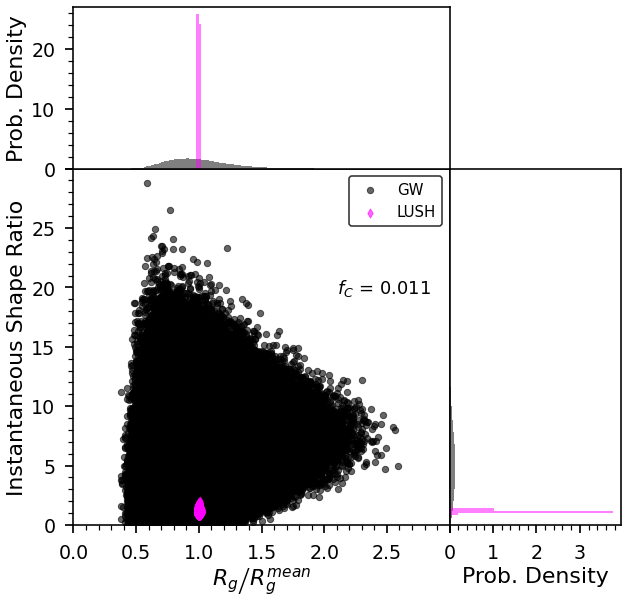

In [27]:


map_2d.plot_protein_against_GW('LUSH')



In [22]:
map_2d.check_boundary()

100.00% of protein snapshots are close to GW snapshots


if it takes too long to run, please consider a higher snapshot interval
CPU times: user 1min 44s, sys: 898 ms, total: 1min 45s
Wall time: 1min 45s


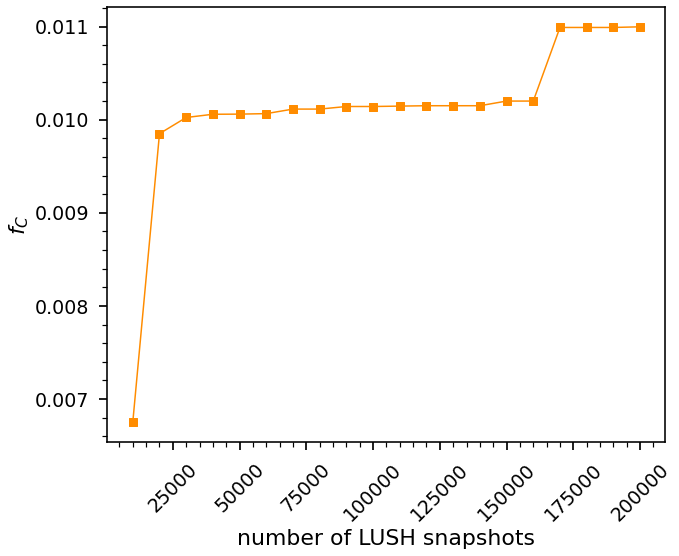

In [21]:
%%time
#faster
map_2d.vary_protein('LUSH',10000)

if it takes too long to run, please consider a higher snapshot interval


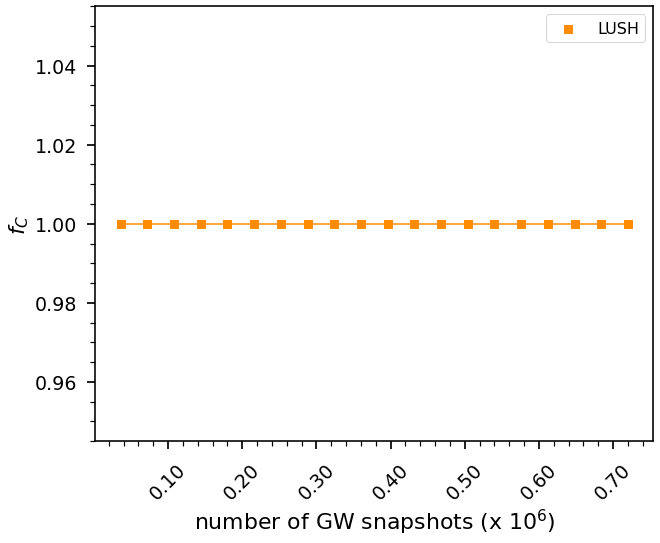

In [18]:
map_2d.vary_GW_ref('LUSH', 36000)

if it takes too long to run, please consider a higher snapshot interval
CPU times: user 2min 16s, sys: 20.3 s, total: 2min 37s
Wall time: 2min 37s


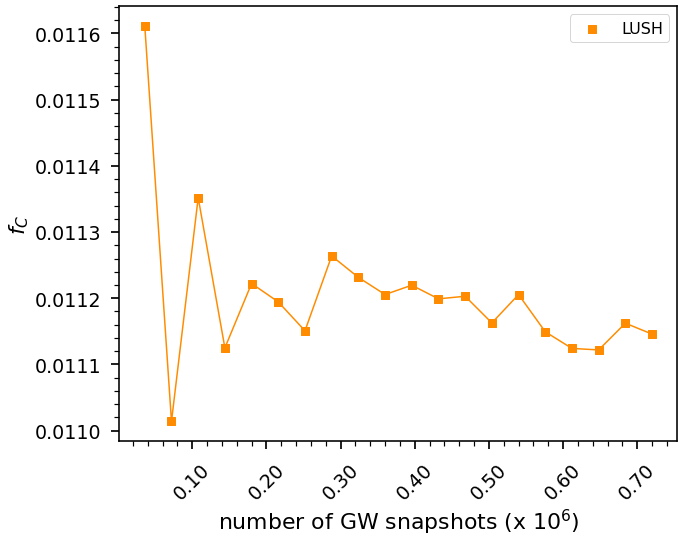

In [25]:
%%time
map_2d.vary_GW_ref('LUSH', 36000)

In [78]:
map_2d.change_xlim_ylim(4,40)

New axis limits generated and will be shown the next time 


CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 17.9 µs


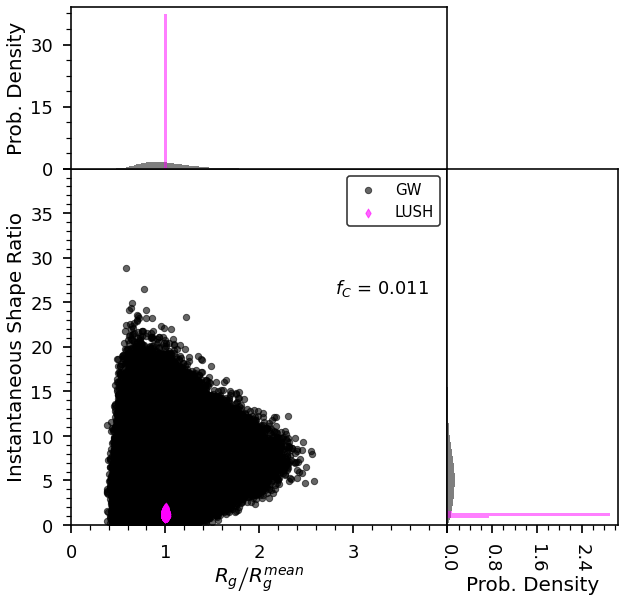

In [79]:

map_2d.plot_protein_against_GW('LUSH')

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 19.1 µs
100000 GW snapshots processed
200000 GW snapshots processed
300000 GW snapshots processed
400000 GW snapshots processed
500000 GW snapshots processed
600000 GW snapshots processed
700000 GW snapshots processed


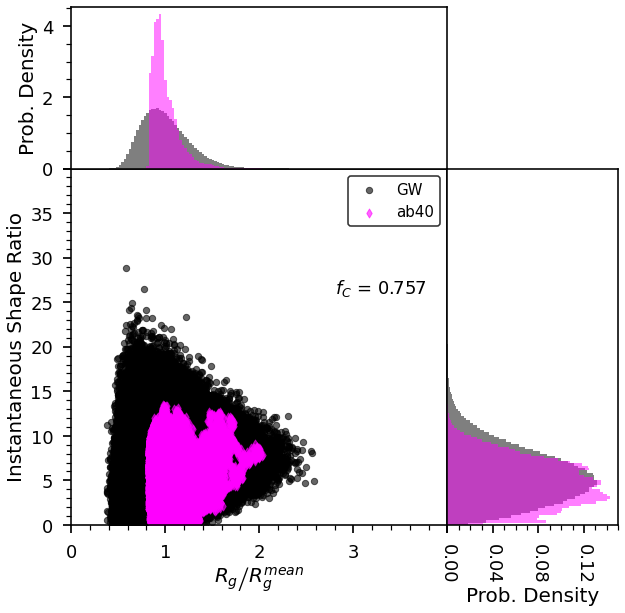

In [12]:
map_2d.plot_protein_against_GW('ab40')

In [4]:
salmon_rg_ree_ratheatmap = pd.read_csv('salmon_rg_ree_ratheatmap.csv')
lush_ESFF1_rg_ree_ratheatmap = pd.read_csv('lush_ESFF1_rg_ree_ratheatmap.csv')
ab40_ff14sb_rg_ree_ratheatmap_noimage = pd.read_csv('ab40_ff14sb_rg_ree_ratheatmap_noimage.csv')

GW_ind_runs_chainlen100_upto24 = pd.read_csv('GW_chainlen100.csv')
GW_ind_runs_chainlen100_upto24['ratio'] = GW_ind_runs_chainlen100_upto24['Rend2'].values/GW_ind_runs_chainlen100_upto24['Rg2'].values


In [5]:
a = list(lush_ESFF1_rg_ree_ratheatmap['Rg'].values**2)
b = list(lush_ESFF1_rg_ree_ratheatmap['Ree'].values**2)

# plot_protein_against_GW(a,
#                         b,'ab40','magenta')

# check_boundary(a,
#                b,
#                'ab40',GW_ind_runs_chainlen100_upto24,len(list(ab40_ff14sb_rg_ree_ratheatmap_noimage['Rg'].values**2)),1,0.1)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
100000 GW snapshots processed
200000 GW snapshots processed
300000 GW snapshots processed
400000 GW snapshots processed
500000 GW snapshots processed
600000 GW snapshots processed
700000 GW snapshots processed


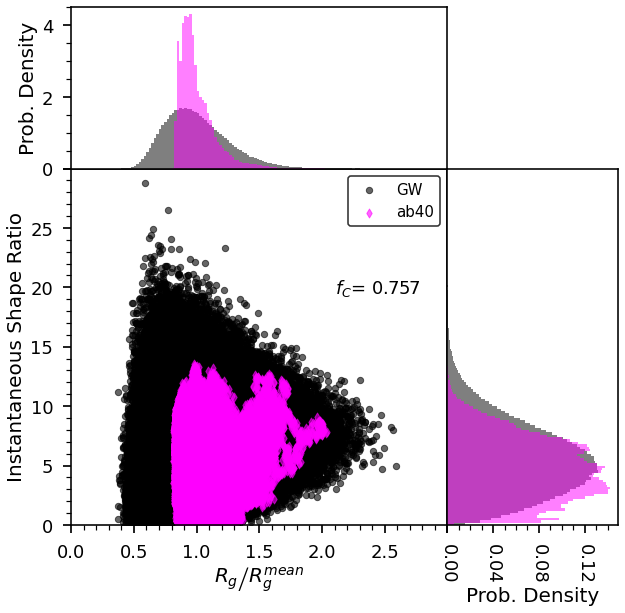

In [31]:
plot_protein_against_GW(list(ab40_ff14sb_rg_ree_ratheatmap_noimage['Rg'].values**2),
                        list(ab40_ff14sb_rg_ree_ratheatmap_noimage['Ree'].values**2),'ab40','magenta')

In [20]:
GW_ind_runs_chainlen100_upto24

,chain_length,Rg2,Rend2,Rg/Rg_mean
0,100,24.502055,250.722530,0.721402
1,100,35.391603,222.164368,0.867015
2,100,64.015070,588.464481,1.166051
3,100,50.672894,251.421442,1.037443
4,100,37.537768,420.887479,0.892916
...,...,...,...,...
719995,100,66.564485,310.775147,1.189043
719996,100,119.291205,972.647027,1.591771
719997,100,74.587018,365.816020,1.258659
719998,100,70.248514,331.818938,1.221504
